# 0. Import the libraries

In [357]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from IPython.core.display import HTML, display
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.over_sampling import SMOTE
from yellowbrick.model_selection import FeatureImportances
import joblib
import os
import pickle
import streamlit as st
#from scipy.stats import norm
%matplotlib inline

# 1. Frame the problem and look at the big picture

## 1.1 Define the objective in business terms.

Determine if the income of a person is greater or less than 50k

## 1.2 How will your solution be used?

The solution can be use in the bank industry for loan applications, it could also be use at the dearship for a car financing.

## 1.3 What are the current solutions/workarounds (if any)?

Not applicable

## 1.4 How should you frame this problem (supervised/unsupervised, online/offline, etc.)

Supervised Learning, Batch learning, Model-based learning.

## 1.5 How should performance be measured?

Classification metrics which are: Accuracy score, Confustion matrix, Classification report, Precision, Recall, F1 score, ROC curve, AUC, Precision-Recall curve

## 1.6 Is the performance measure aligned with the business objective?

Not applicable

## 1.7 What would be the minimum performance needed to reach the business objective?

A subjective accuracy of more than 80%.

## 1.8 What are comparable problems? Can you reuse experience or tools?

Not applicable

## 1.9 Is human expertise available?

No

## 1.10 How would you solve the problem manually?

By looking at each person information and determine if they have an income higher than 50K which is a tedious task.

## 1.11 List the assumptions you or others have made so far.

Some of the assumptions would be that education, occupation, race , gender and native country might influence the target. To be verified

## 1.12 Verify assumptions if possible.

To be verified

# 2. Get the data

## 2.1 List the data you need and how much you need.

Will use the data from the train and test datasets.

## 2.2 Find and document where you can get that data.

Done!

## 2.3 Check how much space it will take.

less than 5 Megabytes.

## 2.4 Check legal obligations, and get the authorization if necessary.

Not applicable

## 2.5 Get access authorizations.

Not applicable

## 2.6 Create a workspace (with enough storage space).

No need

## 2.7 Get the data.

In [358]:
train_original = pd.read_csv('datasets/train.csv')

## 2.8 Convert the data to a format you can easily manipulate (without changing the data itself).

Data already in a good format

## 2.9 Ensure sensitive information is deleted or protected (e.g., anonymized).

Not applicable

## 2.10 Check the size and type of data (time series, sample, geographical, etc.).

~ 5 MB of tabular data

## 2.11 Sample a test set, put it aside, and never look at it (no data snooping!).

In [359]:
test_original = pd.read_csv('datasets/test.csv')

In [360]:
full_data = pd.concat([train_original, test_original], axis=0)

In [361]:
# shuffle the data
full_data = full_data.sample(frac=1).reset_index(drop=True)

In [362]:
full_data.shape

(44856, 15)

In [363]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [364]:
train_original, test_original = data_split(full_data, 0.2)

In [365]:
train_original.shape

(35884, 15)

In [366]:
test_original.shape

(8972, 15)

In [367]:
train_copy = train_original.copy()
test_copy = test_original.copy()

# 3. Explore the data

## 3.1 Create a copy of the data for exploration (sampling it down to a manageable size if necessary).

Not necessary

## 3.2 Create a Jupyter notebook to keep record of your data exploration.

Done!

## 3.3 Quick overview of the data

In [368]:
train_copy.head()

age workclass  fnlwgt     education  educational-num      marital-status  \
0   40   Private  150528     Bachelors               13  Married-civ-spouse   
1   18   Private  174732       HS-grad                9       Never-married   
2   23   Private  162945       HS-grad                9  Married-civ-spouse   
3   23   Private  265148     Bachelors               13       Never-married   
4   29   Private  140863  Some-college               10  Married-civ-spouse   

      occupation    relationship   race gender  capital-gain  capital-loss  \
0   Adm-clerical         Husband  White   Male             0             0   
1  Other-service  Other-relative  Black   Male             0             0   
2          Sales         Husband  White   Male             0          2377   
3          Sales  Other-relative  White   Male             0             0   
4   Tech-support         Husband  White   Male             0             0   

   hours-per-week native-country  income_>50K  
0              40  United-States        0.000  
1              36  United-States        0.000  
2              40  United-States        0.000  
3              55  United-States        0.000  
4              40  United-States        0.000

In [369]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 35883
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              35884 non-null  int64  
 1   workclass        33906 non-null  object 
 2   fnlwgt           35884 non-null  int64  
 3   education        35884 non-null  object 
 4   educational-num  35884 non-null  int64  
 5   marital-status   35884 non-null  object 
 6   occupation       33899 non-null  object 
 7   relationship     35884 non-null  object 
 8   race             35884 non-null  object 
 9   gender           35884 non-null  object 
 10  capital-gain     35884 non-null  int64  
 11  capital-loss     35884 non-null  int64  
 12  hours-per-week   35884 non-null  int64  
 13  native-country   35286 non-null  object 
 14  income_>50K      35146 non-null  float64
dtypes: float64(1), int64(6), object(8)
memory usage: 4.1+ MB


In [370]:
train_copy.describe()

age      fnlwgt  educational-num  capital-gain  capital-loss  \
count 35884.000   35884.000        35884.000     35884.000     35884.000   
mean     38.673  189451.813           10.077      1075.999        87.616   
std      13.681  105621.657            2.572      7455.204       402.927   
min      17.000   13769.000            1.000         0.000         0.000   
25%      28.000  117249.250            9.000         0.000         0.000   
50%      37.000  177937.000           10.000         0.000         0.000   
75%      48.000  237277.250           12.000         0.000         0.000   
max      90.000 1490400.000           16.000     99999.000      4356.000   

       hours-per-week  income_>50K  
count       35884.000    35146.000  
mean           40.388        0.242  
std            12.337        0.428  
min             1.000        0.000  
25%            40.000        0.000  
50%            40.000        0.000  
75%            45.000        0.000  
max            99.000        1.000

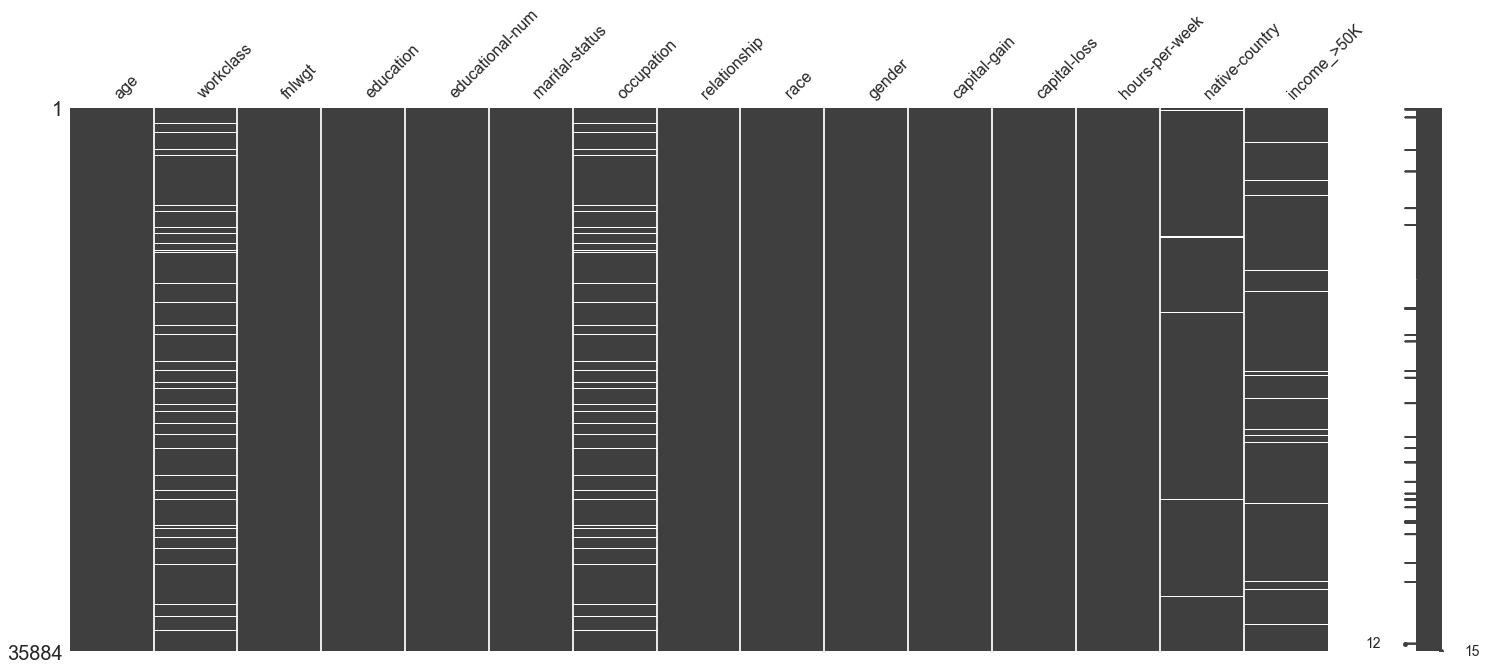

In [371]:
msno.matrix(train_copy)
plt.show()

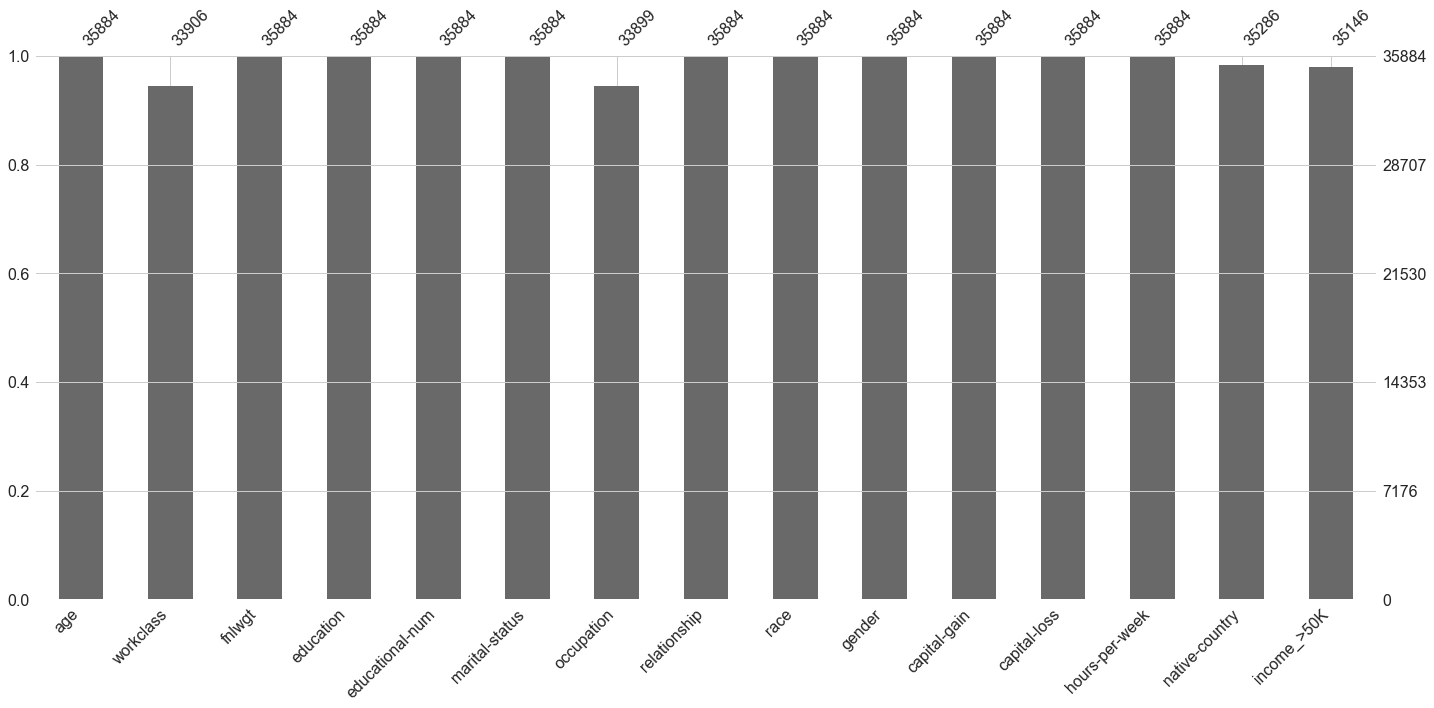

In [372]:
msno.bar(train_copy)
plt.show()

In [373]:
#profile_report = ProfileReport(train_copy, explorative=True, dark_mode=True)

In [374]:
profile_report_file_path = Path('income_class_profile.html')

try:
    profile_report_file_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file("income_class_profile.html")
else:
    pass

## 3.4 Study each attribute and its characteristics:
## - Name
## - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
## - % of missing values
## - Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
## - Possibly useful for the task?
## - Type of distribution (Gaussian, uniform, logarithmic, etc.)

In [375]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

### 3.4.1 Age

In [376]:
train_copy['age'].head()

0    40
1    18
2    23
3    23
4    29
Name: age, dtype: int64

In [377]:
train_copy['age'].describe()

count   35884.000
mean       38.673
std        13.681
min        17.000
25%        28.000
50%        37.000
75%        48.000
max        90.000
Name: age, dtype: float64

In [378]:
train_copy['age'].dtype

dtype('int64')

In [379]:
train_copy['age'].isnull().sum()

0

In [380]:
age_value_cnt_norm = train_copy['age'].value_counts(normalize=True) * 100

In [381]:
age_value_cnt = train_copy['age'].value_counts()

In [382]:
value_cnt_norm_cal(train_copy, 'age')

Count  Frequency (%)
36    997          2.778
31    996          2.776
33    989          2.756
35    979          2.728
23    973          2.712
..    ...            ...
84      6          0.017
88      4          0.011
85      3          0.008
89      1          0.003
87      1          0.003

[73 rows x 2 columns]

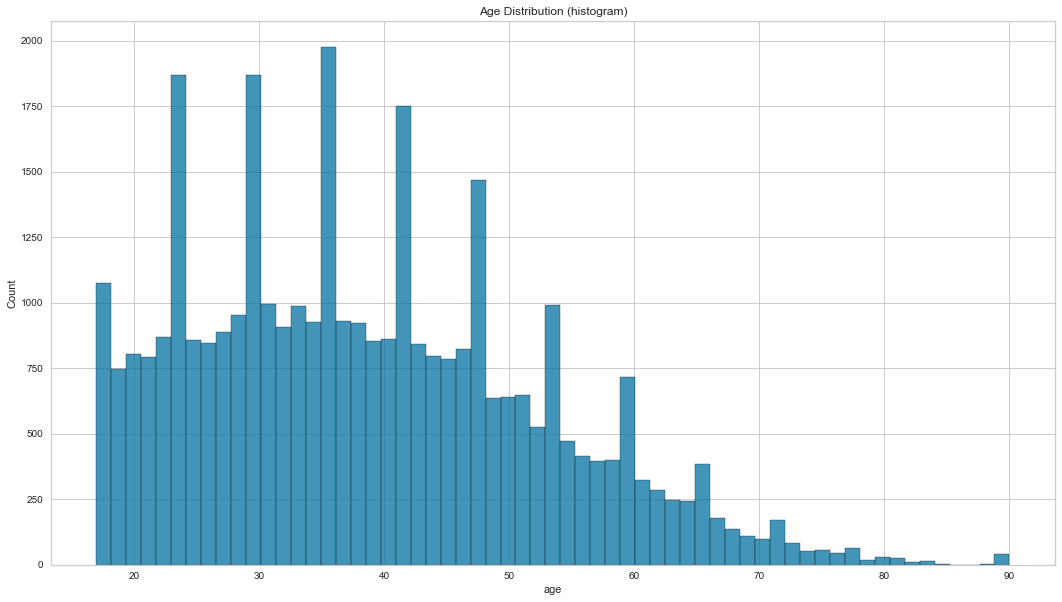

In [383]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['age'])
plt.title('Age Distribution (histogram)')
plt.show()

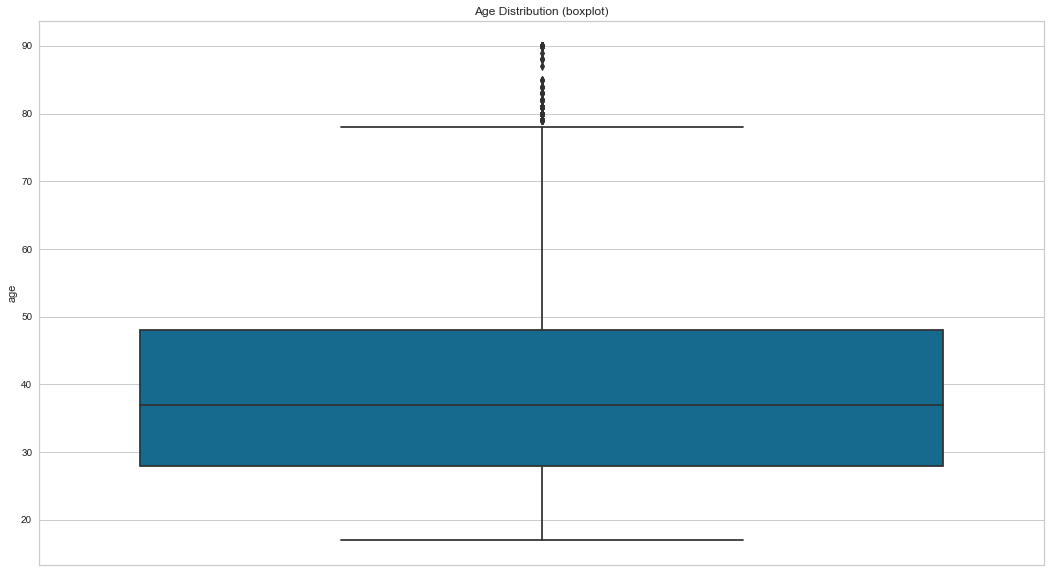

In [384]:
fig, ax = plt.subplots(figsize=(18,10))
sns.boxplot(y=train_copy['age'])
plt.title('Age Distribution (boxplot)')
plt.show()

In [385]:
# TODO: Age is might be useful for the model, will keep it for now

### 3.4.2 Workclass

In [386]:
train_copy['workclass'].dtype

dtype('O')

In [387]:
train_copy['workclass'].head()

0    Private
1    Private
2    Private
3    Private
4    Private
Name: workclass, dtype: object

In [388]:
value_cnt_norm_cal(train_copy,'workclass')

Count  Frequency (%)
Private           24986         73.692
Self-emp-not-inc   2845          8.391
Local-gov          2305          6.798
State-gov          1438          4.241
Self-emp-inc       1257          3.707
Federal-gov        1053          3.106
Without-pay          15          0.044
Never-worked          7          0.021

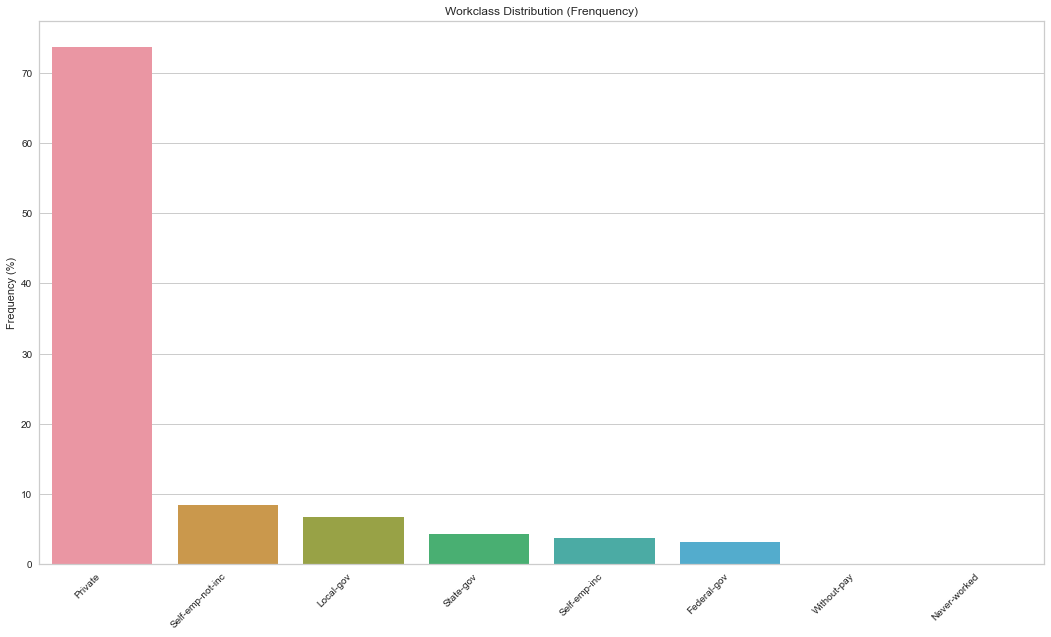

In [389]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'workclass').index, y=value_cnt_norm_cal(train_copy,'workclass')['Frequency (%)'])
plt.title('Workclass Distribution (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

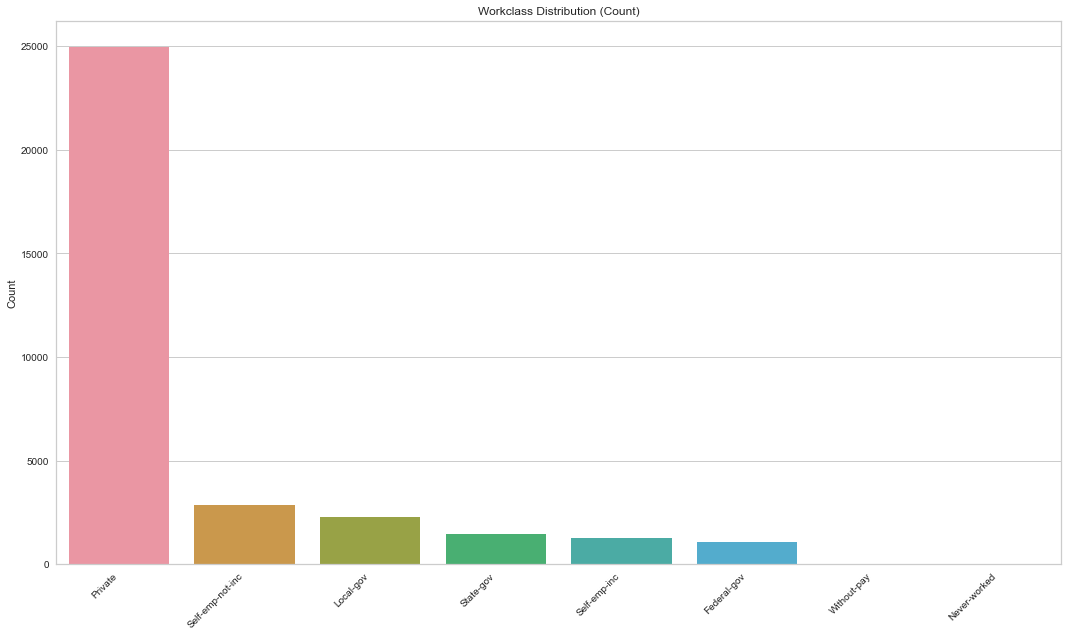

In [390]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'workclass').index, y=value_cnt_norm_cal(train_copy,'workclass')['Count'])
plt.title('Workclass Distribution (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [391]:
train_copy['workclass'].isnull().sum()

1978

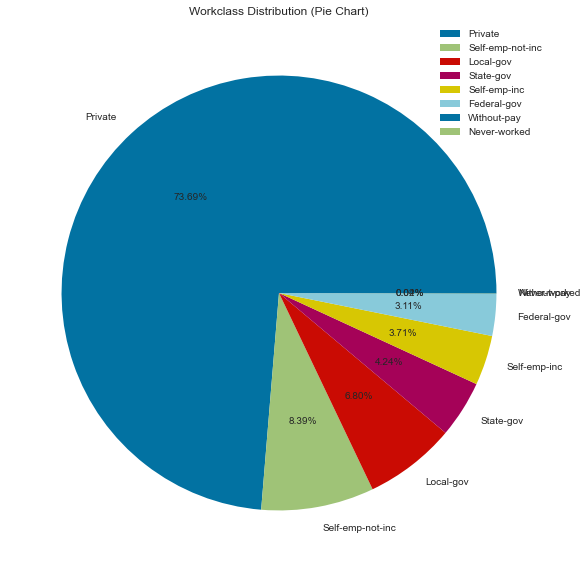

In [392]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['workclass'].value_counts(), labels=train_copy['workclass'].value_counts().index, autopct='%1.2f%%')
plt.title('Workclass Distribution (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [393]:
# TODO: workclass is might be useful for the model, will keep it for now

### 3.4.3 Final weight

Its a weight assigned by the Census Bureau. **The idea is that if two samples have the same(or similar) fnlwgt they have similar characteristics, demographically speaking. **Say sample 7,12 and 33 are having similar fnlwgt values they are more likely to be of the same race, similar educational and social background, etc.. but if you are planning to use it, you should be aware that they are not standardized across different states/country. So someone in one country might share similar fnlwgt with somebody in another country but might have entirely different socio-economic background.

In [394]:
train_copy['fnlwgt'].dtype

dtype('int64')

In [395]:
train_copy['fnlwgt'].head()

0    150528
1    174732
2    162945
3    265148
4    140863
Name: fnlwgt, dtype: int64

In [396]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_copy['fnlwgt'].describe()

count     35884.000
mean     189451.813
std      105621.657
min       13769.000
25%      117249.250
50%      177937.000
75%      237277.250
max     1490400.000
Name: fnlwgt, dtype: float64

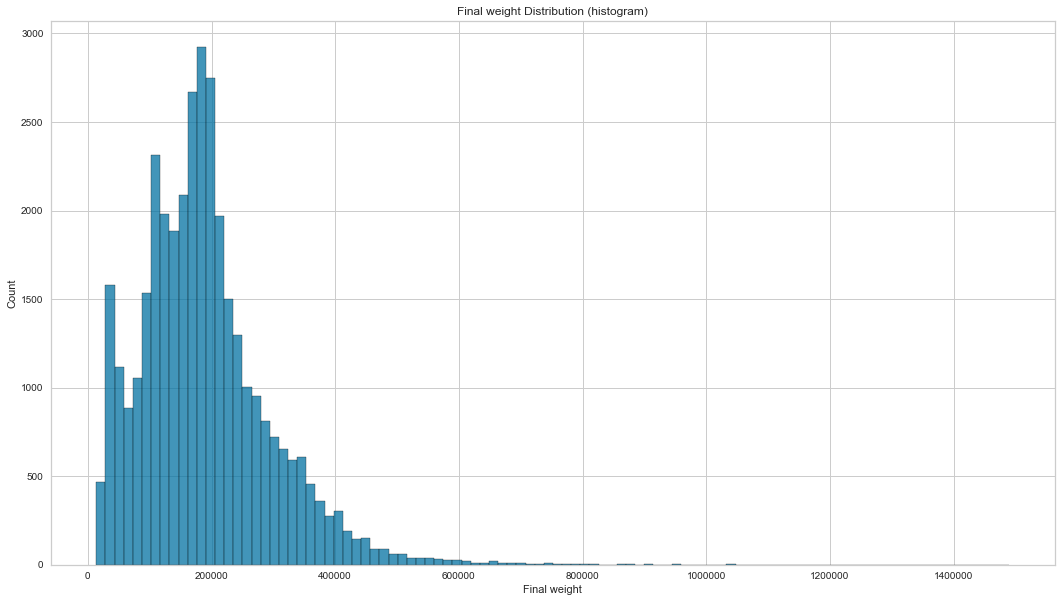

In [397]:
fig, ax = plt.subplots(figsize=(18,10))
ax.ticklabel_format(style='plain')
sns.histplot(train_copy['fnlwgt'],bins=100)
plt.title('Final weight Distribution (histogram)')
plt.xlabel('Final weight')
plt.show()

In [398]:
# TODO: Not sure if this feature is useful, will keep it for now. Will run the feature im and see if this is useful

### 3.4.4. Education

In [399]:
train_copy['education'].dtype

dtype('O')

In [400]:
train_copy['education'].head()

0       Bachelors
1         HS-grad
2         HS-grad
3       Bachelors
4    Some-college
Name: education, dtype: object

In [401]:
train_copy['education'].isnull().sum()

0

In [402]:
value_cnt_norm_cal(train_copy,'education')

Count  Frequency (%)
HS-grad       11605         32.340
Some-college   7983         22.247
Bachelors      5867         16.350
Masters        1989          5.543
Assoc-voc      1505          4.194
11th           1358          3.784
Assoc-acdm     1174          3.272
10th           1016          2.831
7th-8th         704          1.962
Prof-school     614          1.711
9th             544          1.516
12th            475          1.324
Doctorate       429          1.196
5th-6th         383          1.067
1st-4th         177          0.493
Preschool        61          0.170

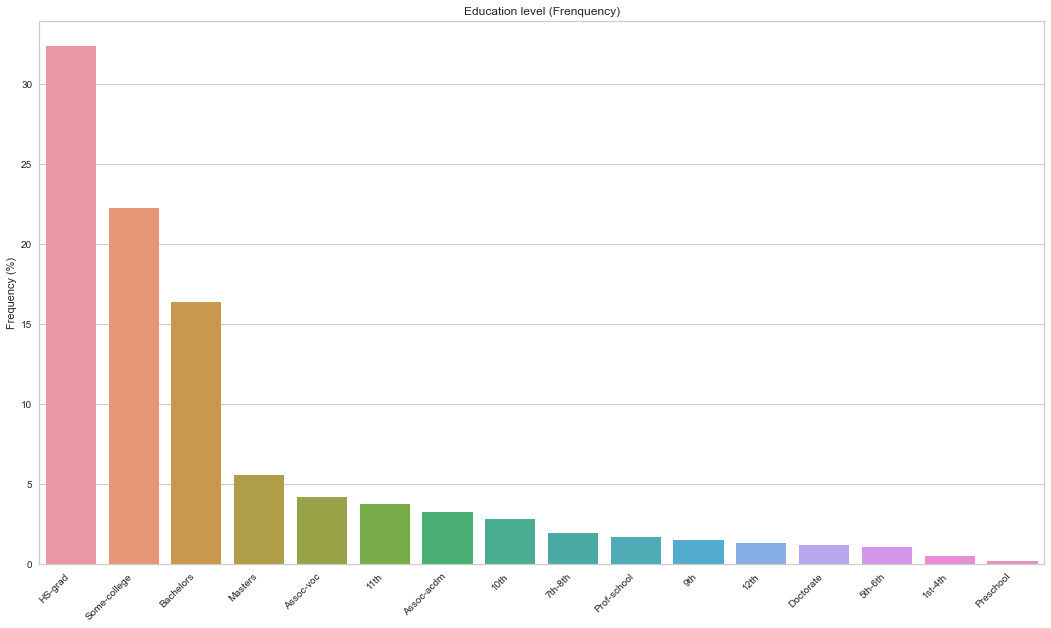

In [403]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'education').index, y=value_cnt_norm_cal(train_copy,'education')['Frequency (%)'])
plt.title('Education level (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

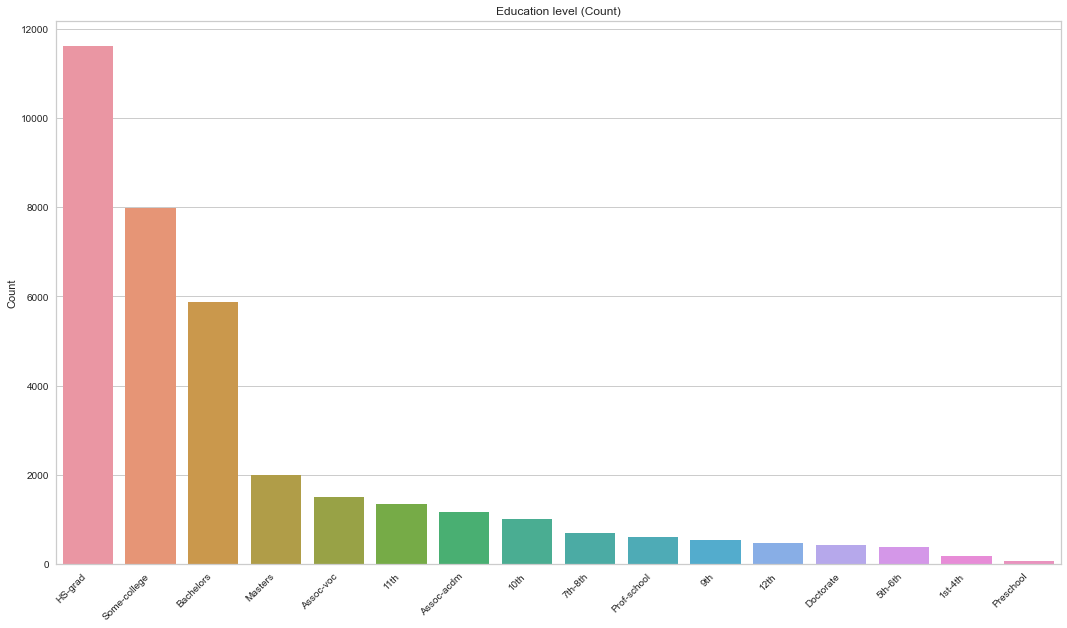

In [404]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'education').index, y=value_cnt_norm_cal(train_copy,'education')['Count'])
plt.title('Education level (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [405]:
# TODO: education level is might be useful for the model, will keep it for now

### 3.4.5 education number

In [406]:
train_copy['educational-num'].dtype

dtype('int64')

In [407]:
train_copy['educational-num'].head()

0    13
1     9
2     9
3    13
4    10
Name: educational-num, dtype: int64

In [408]:
train_copy['educational-num'].value_counts()

9     11605
10     7983
13     5867
14     1989
11     1505
7      1358
12     1174
6      1016
4       704
15      614
5       544
8       475
16      429
3       383
2       177
1        61
Name: educational-num, dtype: int64

In [409]:
train_copy[['education','educational-num']].nunique()

education          16
educational-num    16
dtype: int64

In [410]:
train_copy[['education','educational-num']].value_counts()

education     educational-num
HS-grad       9                  11605
Some-college  10                  7983
Bachelors     13                  5867
Masters       14                  1989
Assoc-voc     11                  1505
11th          7                   1358
Assoc-acdm    12                  1174
10th          6                   1016
7th-8th       4                    704
Prof-school   15                   614
9th           5                    544
12th          8                    475
Doctorate     16                   429
5th-6th       3                    383
1st-4th       2                    177
Preschool     1                     61
dtype: int64

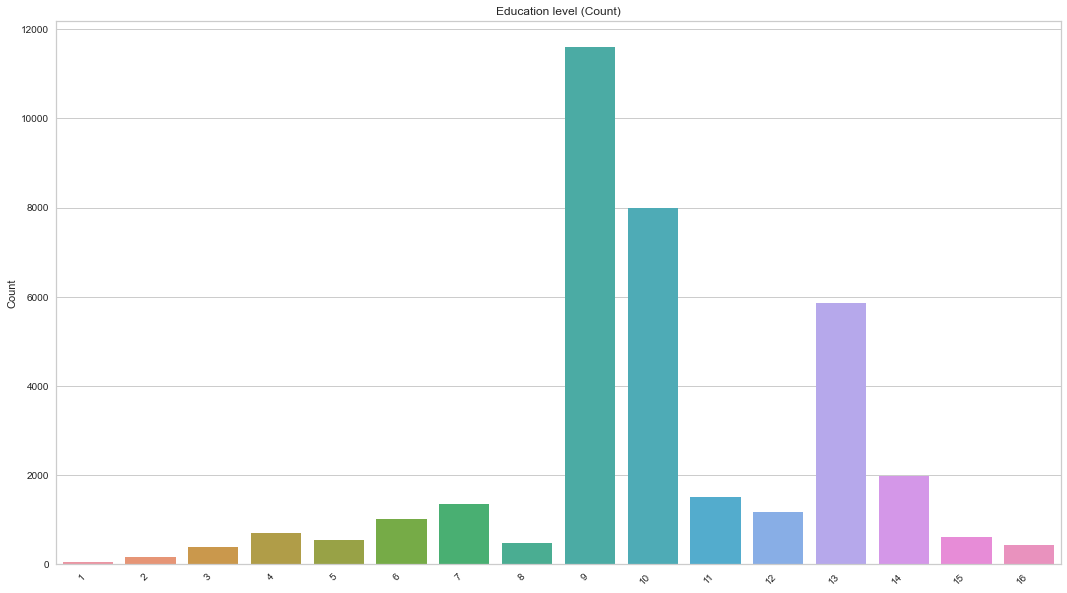

In [411]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'educational-num').index, y=value_cnt_norm_cal(train_copy,'educational-num')['Count'])
plt.title('Education level (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [412]:
# TODO: since education-num is essentially an encoded version of education, will need to drop this feature and keep education for now.

### 3.4.6 Marital Status

In [413]:
train_copy['marital-status'].dtype

dtype('O')

In [414]:
train_copy['marital-status'].head()

0    Married-civ-spouse
1         Never-married
2    Married-civ-spouse
3         Never-married
4    Married-civ-spouse
Name: marital-status, dtype: object

In [415]:
train_copy['marital-status'].isnull().sum()

0

In [416]:
value_cnt_norm_cal(train_copy,'marital-status')

Count  Frequency (%)
Married-civ-spouse     16463         45.878
Never-married          11781         32.831
Divorced                4898         13.650
Widowed                 1124          3.132
Separated               1122          3.127
Married-spouse-absent    467          1.301
Married-AF-spouse         29          0.081

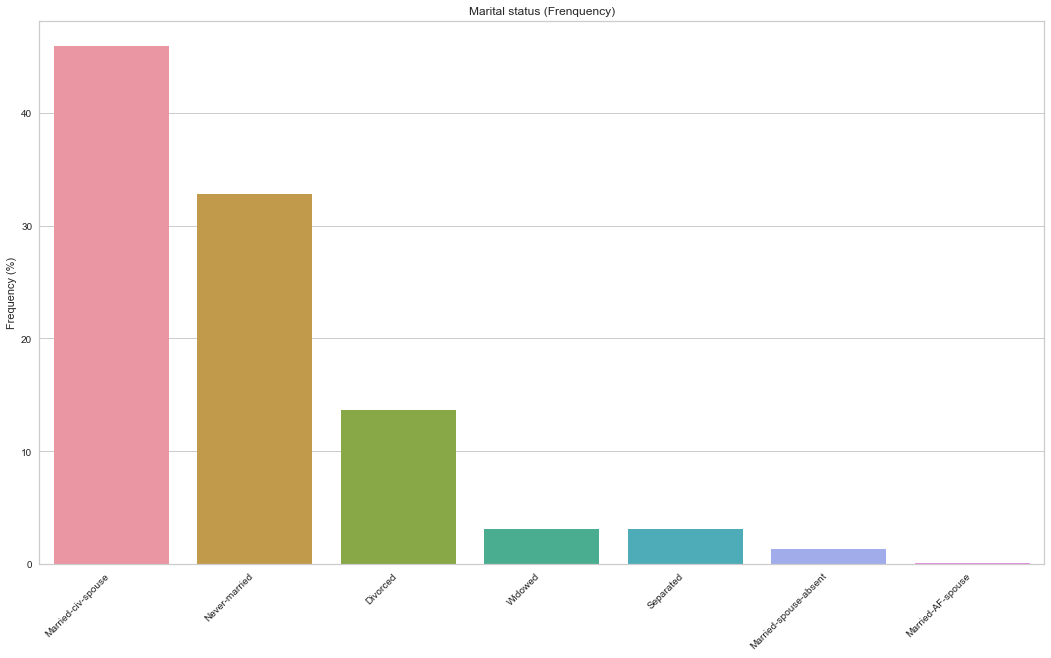

In [417]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'marital-status').index, y=value_cnt_norm_cal(train_copy,'marital-status')['Frequency (%)'])
plt.title('Marital status (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

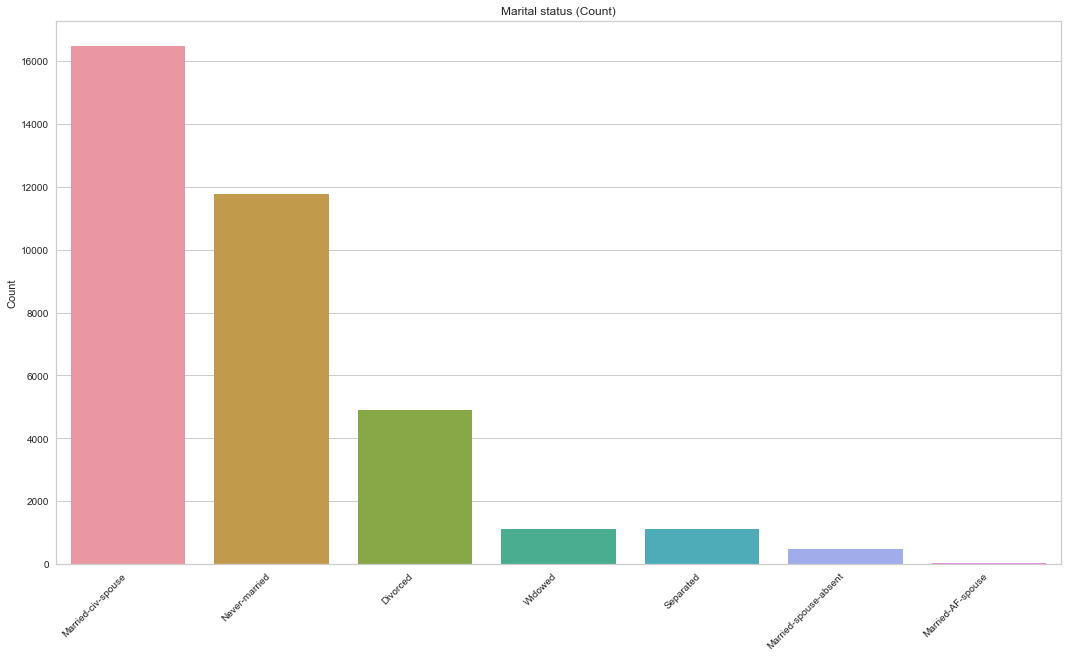

In [418]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'marital-status').index, y=value_cnt_norm_cal(train_copy,'marital-status')['Count'])
plt.title('Marital status (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

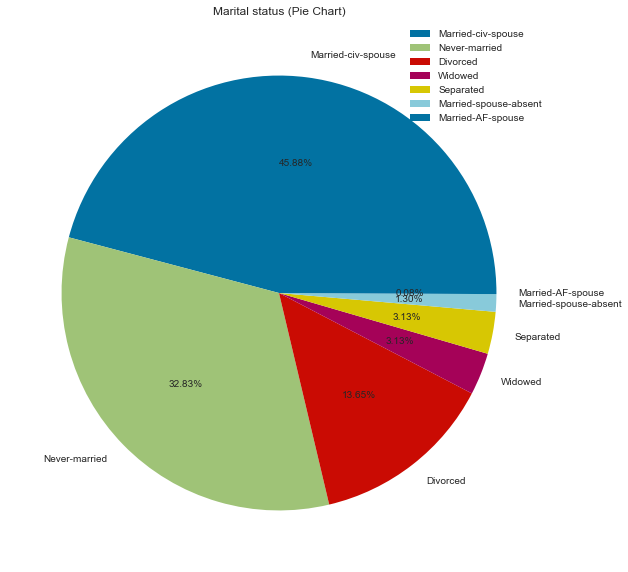

In [419]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['marital-status'].value_counts(), labels=train_copy['marital-status'].value_counts().index, autopct='%1.2f%%')
plt.title('Marital status (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

### 3.4.7 Occupation

In [420]:
train_copy['occupation'].dtype

dtype('O')

In [421]:
train_copy['occupation'].head()

0     Adm-clerical
1    Other-service
2            Sales
3            Sales
4     Tech-support
Name: occupation, dtype: object

In [422]:
train_copy['occupation'].isnull().sum()

1985

In [423]:
train_copy['occupation'].value_counts()

Craft-repair         4591
Exec-managerial      4547
Prof-specialty       4526
Adm-clerical         4095
Sales                4018
Other-service        3601
Machine-op-inspct    2218
Transport-moving     1735
Handlers-cleaners    1525
Tech-support         1075
Farming-fishing      1064
Protective-serv       713
Priv-house-serv       181
Armed-Forces           10
Name: occupation, dtype: int64

In [424]:
train_copy['occupation'].nunique()

14

In [425]:
value_cnt_norm_cal(train_copy,'occupation')

Count  Frequency (%)
Craft-repair        4591         13.543
Exec-managerial     4547         13.413
Prof-specialty      4526         13.351
Adm-clerical        4095         12.080
Sales               4018         11.853
Other-service       3601         10.623
Machine-op-inspct   2218          6.543
Transport-moving    1735          5.118
Handlers-cleaners   1525          4.499
Tech-support        1075          3.171
Farming-fishing     1064          3.139
Protective-serv      713          2.103
Priv-house-serv      181          0.534
Armed-Forces          10          0.029

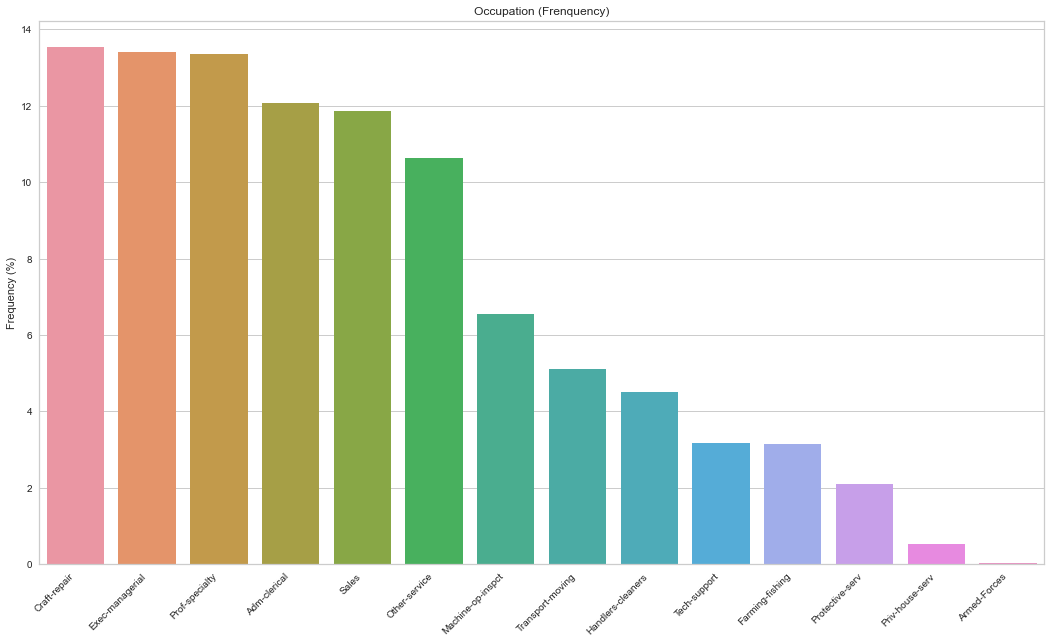

In [426]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'occupation').index, y=value_cnt_norm_cal(train_copy,'occupation')['Frequency (%)'])
plt.title('Occupation (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

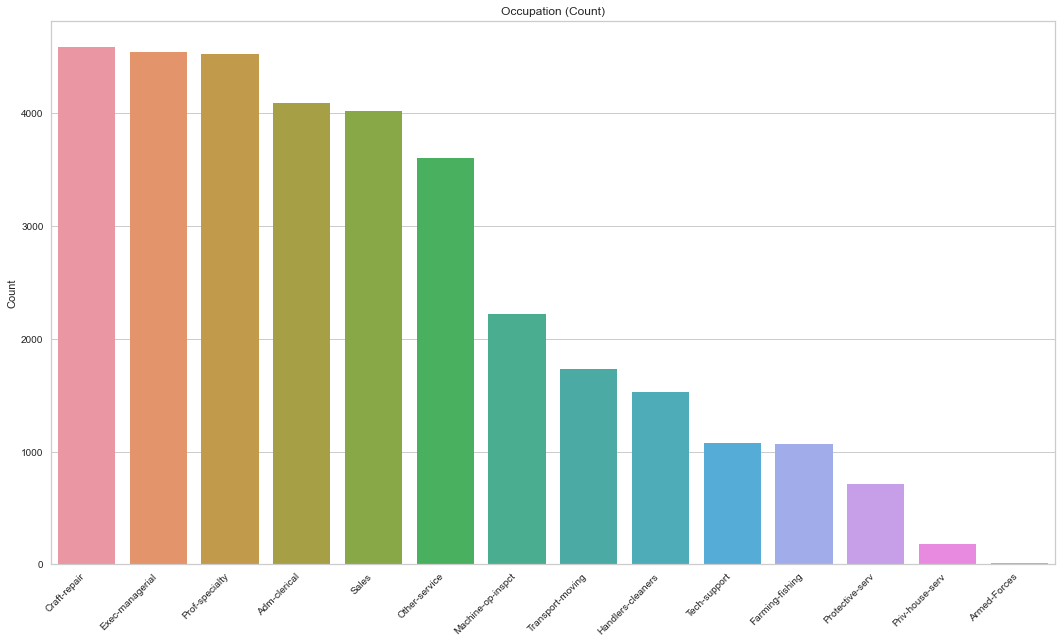

In [427]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'occupation').index, y=value_cnt_norm_cal(train_copy,'occupation')['Count'])
plt.title('Occupation (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [428]:
## TODO: occupation is highly correlated with workclass, has almost the same missing value like workclass and gives less info than workclass. we might need to drop this feature.

### 3.4.8 relationship

In [429]:
train_copy['relationship'].dtype

dtype('O')

In [430]:
train_copy['relationship'].head()

0           Husband
1    Other-relative
2           Husband
3    Other-relative
4           Husband
Name: relationship, dtype: object

In [431]:
train_copy['relationship'].value_counts()

Husband           14513
Not-in-family      9277
Own-child          5550
Unmarried          3744
Wife               1701
Other-relative     1099
Name: relationship, dtype: int64

In [432]:
train_copy['relationship'].isnull().sum()

0

In [433]:
value_cnt_norm_cal(train_copy,'relationship')

Count  Frequency (%)
Husband         14513         40.444
Not-in-family    9277         25.853
Own-child        5550         15.467
Unmarried        3744         10.434
Wife             1701          4.740
Other-relative   1099          3.063

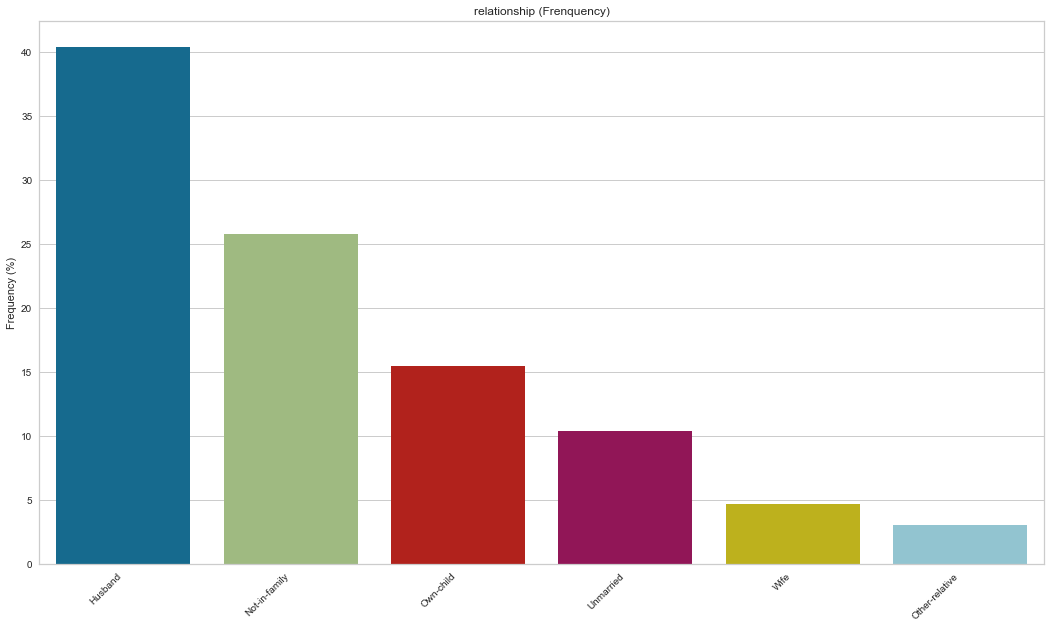

In [434]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'relationship').index, y=value_cnt_norm_cal(train_copy,'relationship')['Frequency (%)'])
plt.title('relationship (Frenquency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

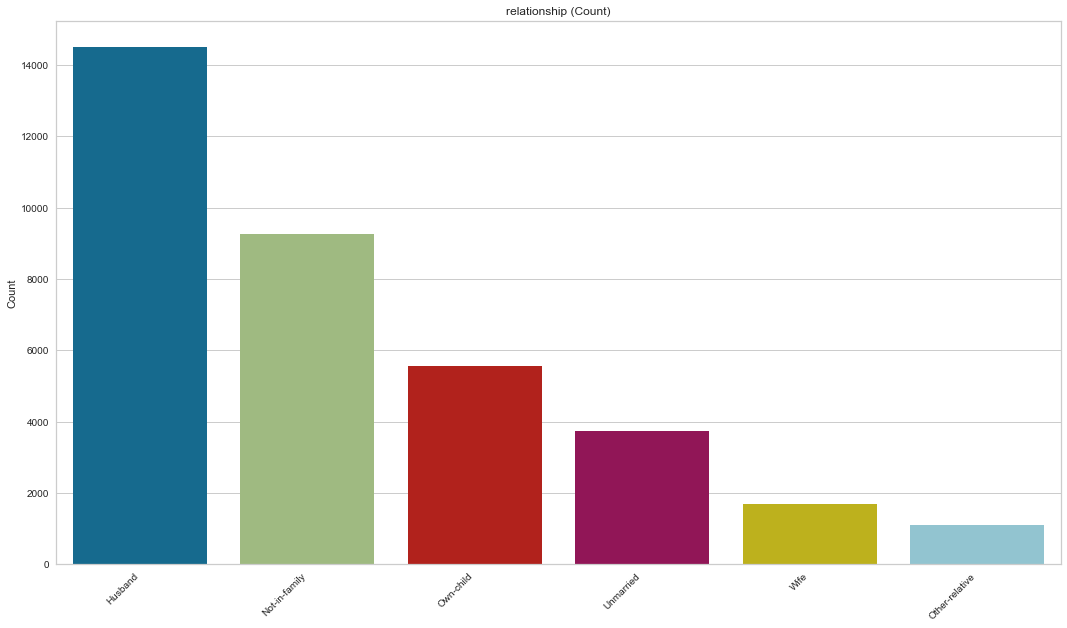

In [435]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'relationship').index, y=value_cnt_norm_cal(train_copy,'relationship')['Count'])
plt.title('relationship (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

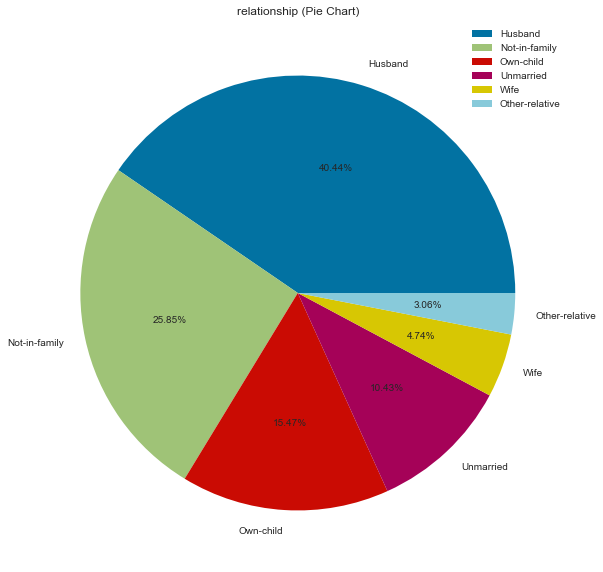

In [436]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['relationship'].value_counts(), labels=train_copy['relationship'].value_counts().index, autopct='%1.2f%%')
plt.title('relationship (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [437]:
# TODO: relationship is highly correlated with Marital status. we might need to drop this feature.

### 3.4.9 Race

In [438]:
train_copy['race'].dtype

dtype('O')

In [439]:
train_copy['race'].isnull().sum()

0

In [440]:
train_copy['race'].head()

0    White
1    Black
2    White
3    White
4    White
Name: race, dtype: object

In [441]:
value_cnt_norm_cal(train_copy,'race')

Count  Frequency (%)
White               30726         85.626
Black                3410          9.503
Asian-Pac-Islander   1107          3.085
Amer-Indian-Eskimo    342          0.953
Other                 299          0.833

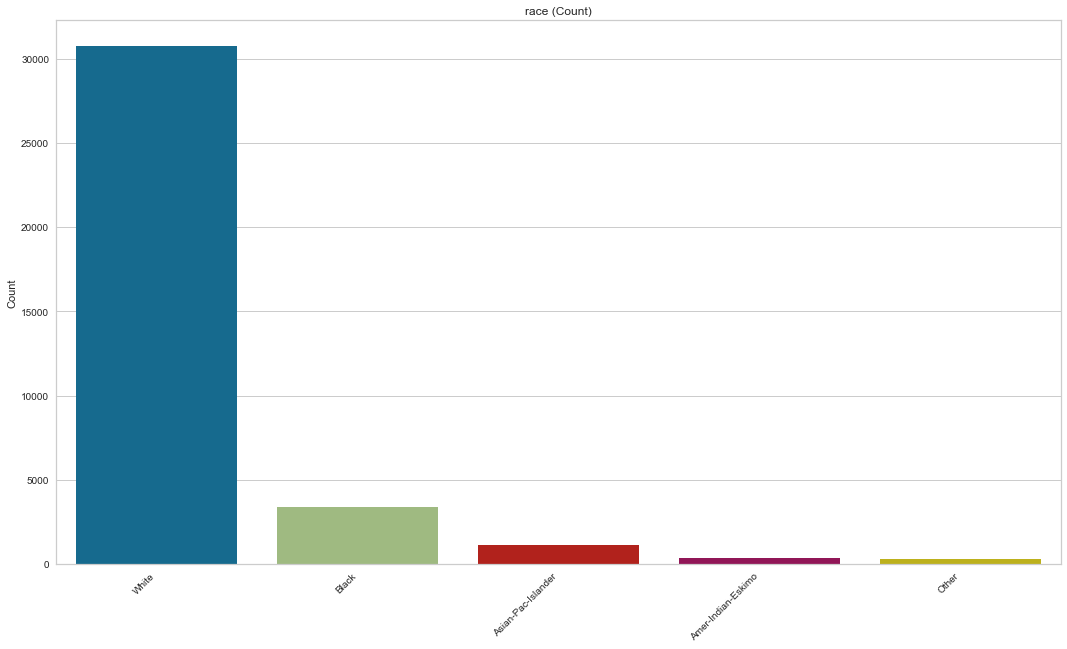

In [442]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'race').index, y=value_cnt_norm_cal(train_copy,'race')['Count'])
plt.title('race (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

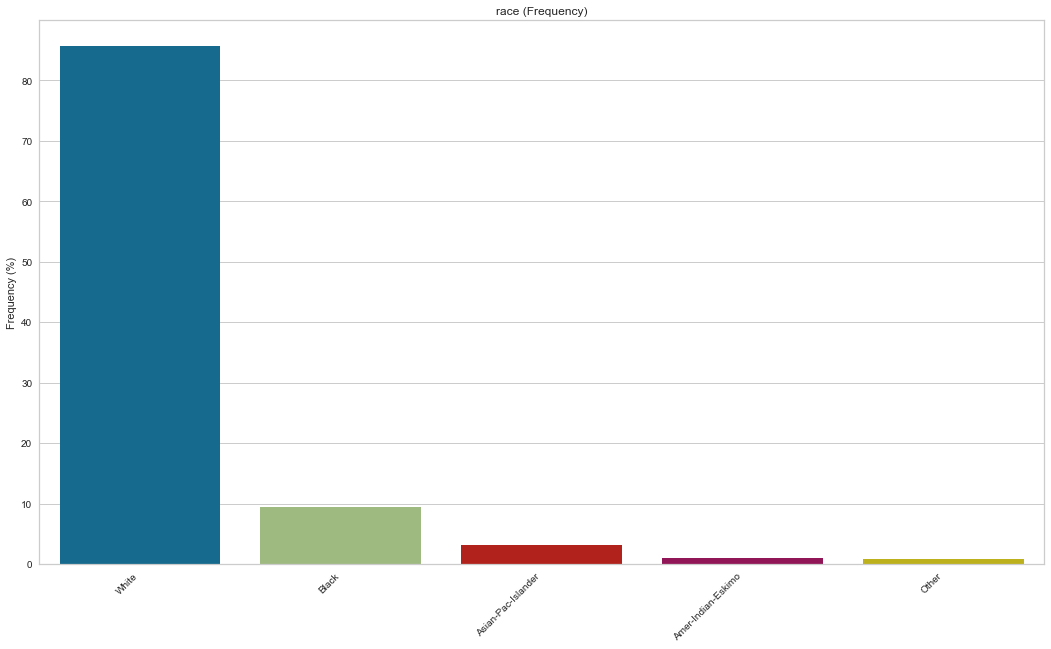

In [443]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'race').index, y=value_cnt_norm_cal(train_copy,'race')['Frequency (%)'])
plt.title('race (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

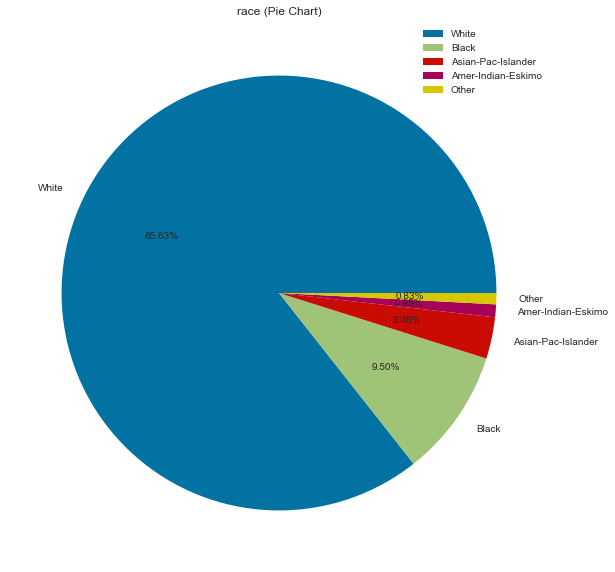

In [444]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['race'].value_counts(), labels=train_copy['race'].value_counts().index, autopct='%1.2f%%')
plt.title('race (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [445]:
# TODO: Race might influence on the salary. will keep it

### 3.4.10 Gender

In [446]:
train_copy['gender'].dtype

dtype('O')

In [447]:
train_copy['race'].isnull().sum()

0

In [448]:
value_cnt_norm_cal(train_copy,'gender')

Count  Frequency (%)
Male    24049         67.019
Female  11835         32.981

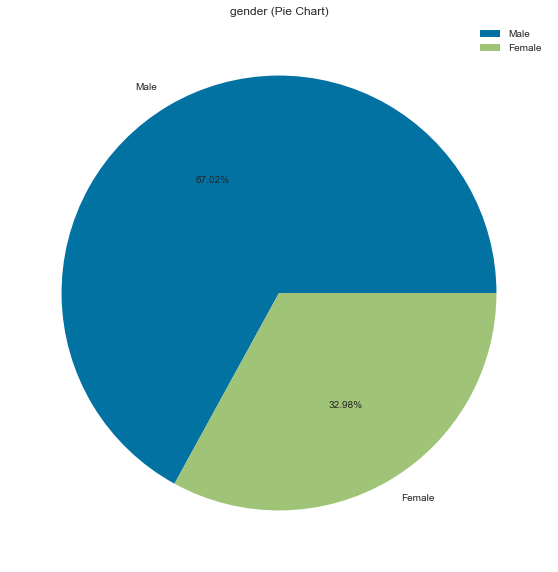

In [449]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['gender'].value_counts(), labels=train_copy['gender'].value_counts().index, autopct='%1.2f%%')
plt.title('gender (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

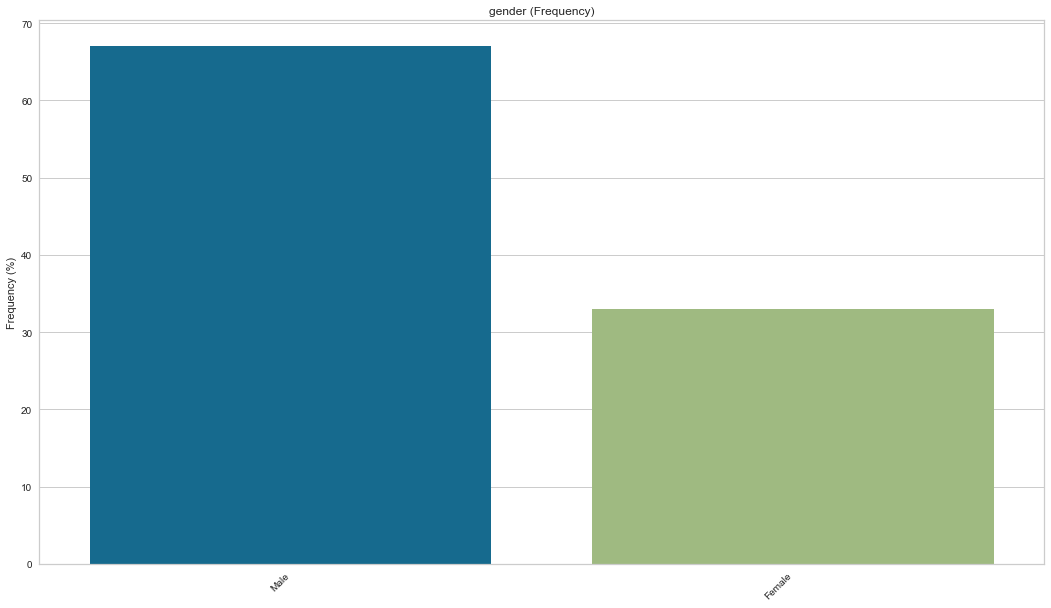

In [450]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'gender').index, y=value_cnt_norm_cal(train_copy,'gender')['Frequency (%)'])
plt.title('gender (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

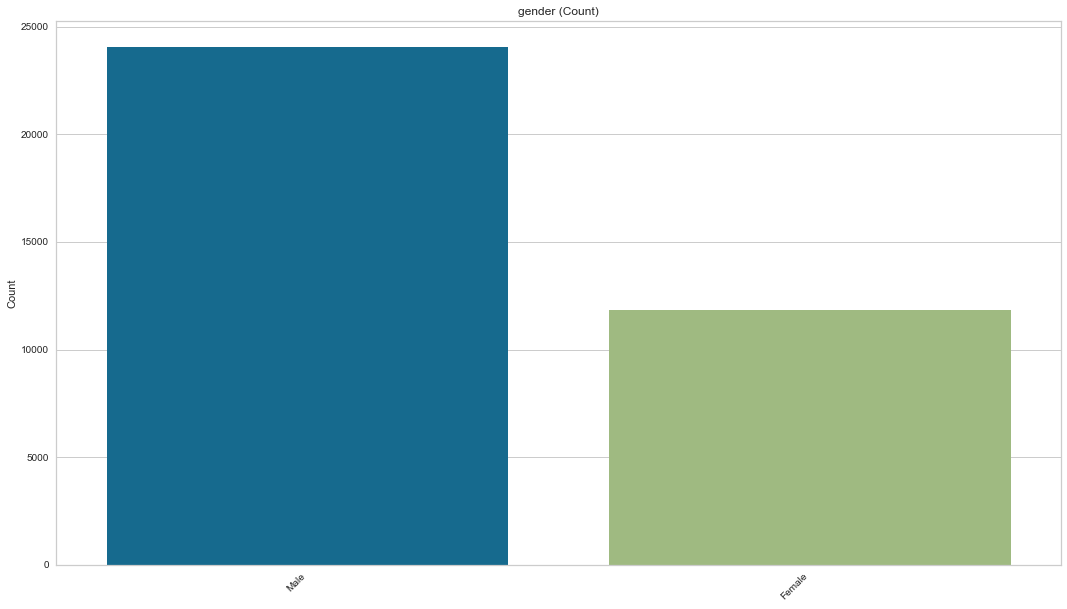

In [451]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'gender').index, y=value_cnt_norm_cal(train_copy,'gender')['Count'])
plt.title('gender (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [452]:
# TODO: Gender might influence on the salary. will keep it

### 3.4.11 capital gain

In [453]:
train_copy['capital-gain'].dtype

dtype('int64')

In [454]:
train_copy['capital-gain'].describe()

count   35884.000
mean     1075.999
std      7455.204
min         0.000
25%         0.000
50%         0.000
75%         0.000
max     99999.000
Name: capital-gain, dtype: float64

In [455]:
train_copy['capital-gain'].isnull().sum()

0

In [456]:
train_copy['capital-gain'].value_counts()

0        32918
15024      364
7688       303
7298       277
99999      180
         ...  
6612         1
2936         1
1264         1
1731         1
1639         1
Name: capital-gain, Length: 121, dtype: int64

In [457]:
train_copy['capital-gain'].shape

(35884,)

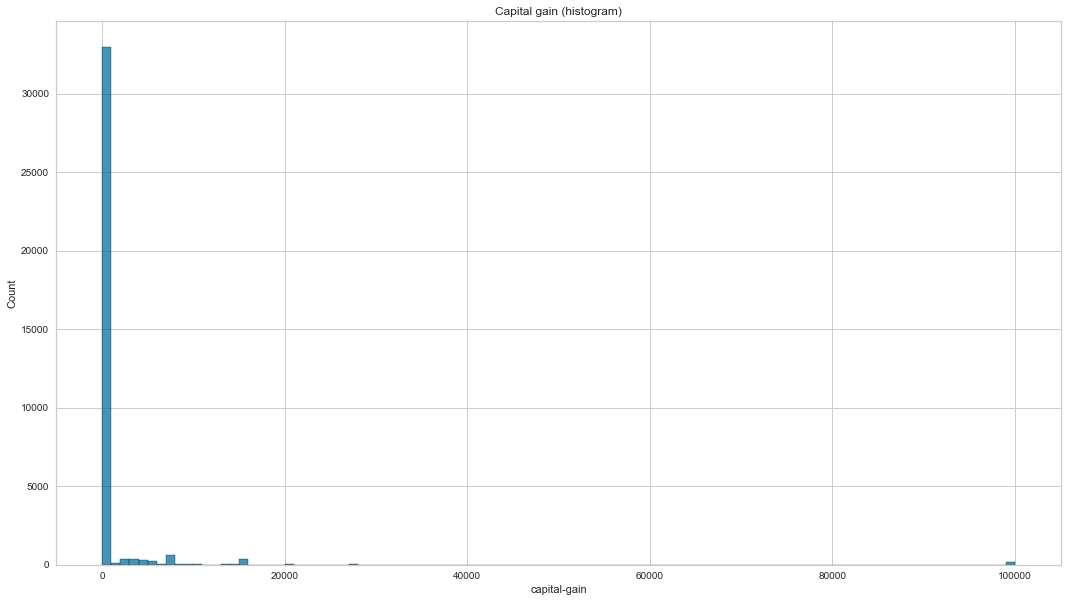

In [458]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['capital-gain'],bins=100)
plt.title('Capital gain (histogram)')
plt.show()

In [459]:
# TODO: Capital gain is very skewed and contains a lot of zeros. we might need to drop this feature.

### 3.4.12 capital loss

In [460]:
train_copy['capital-loss'].dtype

dtype('int64')

In [461]:
train_copy['capital-loss'].describe()

count   35884.000
mean       87.616
std       402.927
min         0.000
25%         0.000
50%         0.000
75%         0.000
max      4356.000
Name: capital-loss, dtype: float64

In [462]:
train_copy['capital-loss'].isnull().sum()

0

In [463]:
train_copy['capital-loss'].value_counts()

0       34203
1902      231
1977      185
1887      166
1848       55
        ...  
2352        1
1539        1
1844        1
2282        1
2163        1
Name: capital-loss, Length: 97, dtype: int64

In [464]:
train_copy['capital-loss'].shape

(35884,)

In [465]:
value_cnt_norm_cal(train_copy,'capital-loss')

Count  Frequency (%)
0     34203         95.315
1902    231          0.644
1977    185          0.516
1887    166          0.463
1848     55          0.153
...     ...            ...
2352      1          0.003
1539      1          0.003
1844      1          0.003
2282      1          0.003
2163      1          0.003

[97 rows x 2 columns]

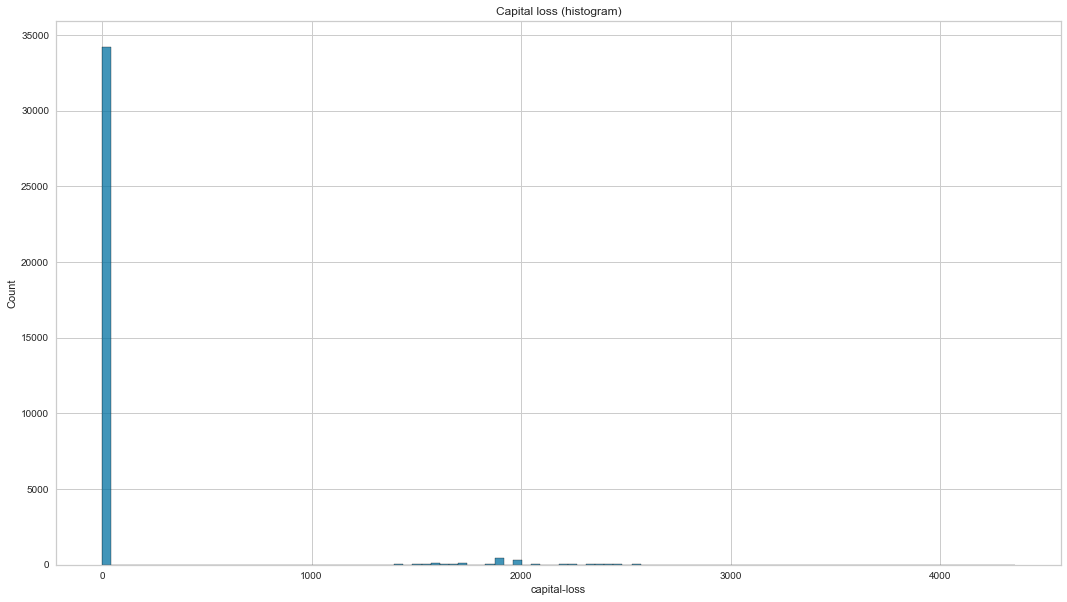

In [466]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['capital-loss'],bins=100)
plt.title('Capital loss (histogram)')
plt.show()

In [467]:
# TODO: Capital loss is very skewed and contains a lot of zeros. we might need to drop this feature.

### 3.4.13 Hours per week

In [468]:
train_copy['hours-per-week'].dtype

dtype('int64')

In [469]:
train_copy['hours-per-week'].describe()

count   35884.000
mean       40.388
std        12.337
min         1.000
25%        40.000
50%        40.000
75%        45.000
max        99.000
Name: hours-per-week, dtype: float64

In [470]:
value_cnt_norm_cal(train_copy,'hours-per-week')

Count  Frequency (%)
40  16789         46.787
50   3137          8.742
45   1995          5.560
60   1573          4.384
35   1415          3.943
..    ...            ...
81      2          0.006
95      2          0.006
94      1          0.003
74      1          0.003
87      1          0.003

[93 rows x 2 columns]

In [471]:
train_copy['hours-per-week'].isnull().sum()

0

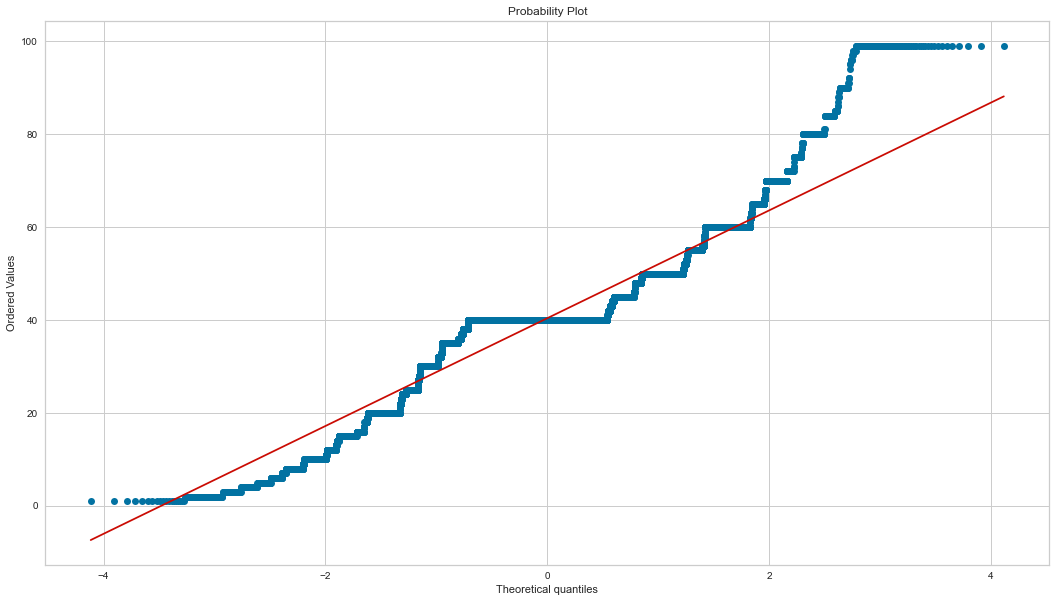

In [472]:
#checking if hours-per-week is normally distributed
fig, ax = plt.subplots(figsize=(18,10))
probplot(train_copy['hours-per-week'], dist="norm", plot=ax)
plt.show()

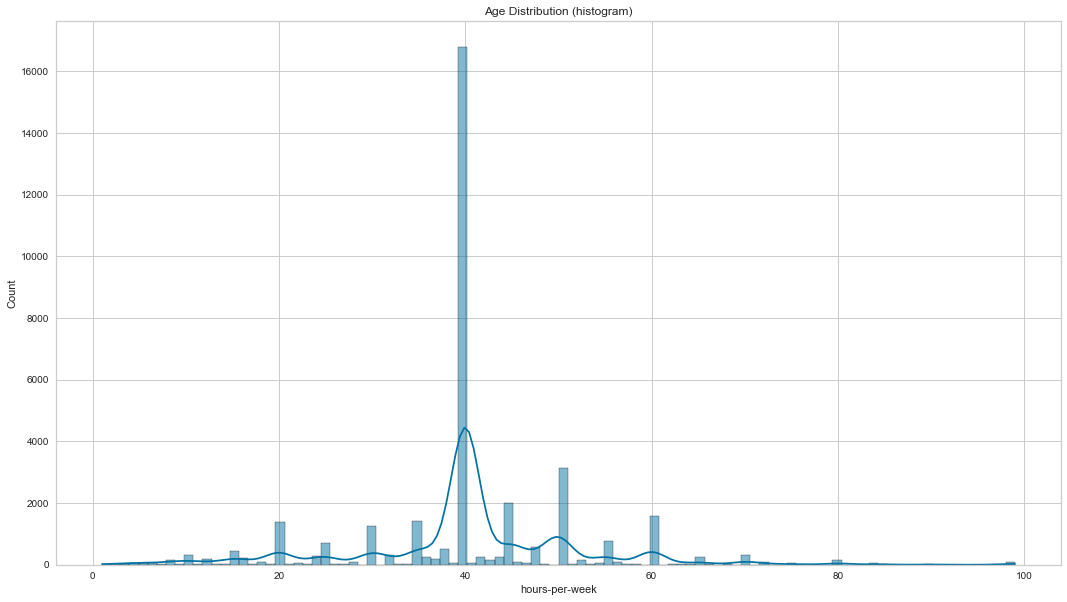

In [473]:
fig, ax = plt.subplots(figsize=(18,10))
sns.histplot(train_copy['hours-per-week'],bins=100,kde=True)
plt.title('Age Distribution (histogram)')
plt.show()

In [474]:
# TODO: Hours per week might be useful. will keep it

### 3.4.14 Native country

In [475]:
train_copy['native-country'].dtype

dtype('O')

In [476]:
train_copy['native-country'].isnull().sum()

598

In [477]:
value_cnt_norm_cal(train_copy,'native-country')

Count  Frequency (%)
United-States               32213         91.291
Mexico                        695          1.970
Philippines                   219          0.621
Germany                       161          0.456
Puerto-Rico                   139          0.394
Canada                        131          0.371
El-Salvador                   117          0.332
Cuba                          109          0.309
England                       107          0.303
India                         102          0.289
China                          95          0.269
South korea                    93          0.264
Jamaica                        80          0.227
Italy                          79          0.224
Dominican-Republic             78          0.221
Japan                          66          0.187
Guatemala                      65          0.184
Vietnam                        62          0.176
Poland                         61          0.173
Columbia                       59          0.167
Haiti                          55          0.156
Portugal                       50          0.142
Taiwan                         45          0.128
Greece                         42          0.119
Nicaragua                      42          0.119
Iran                           40          0.113
Ecuador                        37          0.105
France                         29          0.082
Ireland                        26          0.074
Thailand                       25          0.071
Peru                           24          0.068
Cambodia                       22          0.062
Trinadad&Tobago                20          0.057
Hong-Kong                      19          0.054
Laos                           18          0.051
Honduras                       16          0.045
Outlying-US(Guam-USVI-etc)     16          0.045
Hungary                        15          0.043
Yugoslavia                     13          0.037
Netherlands                     1          0.003

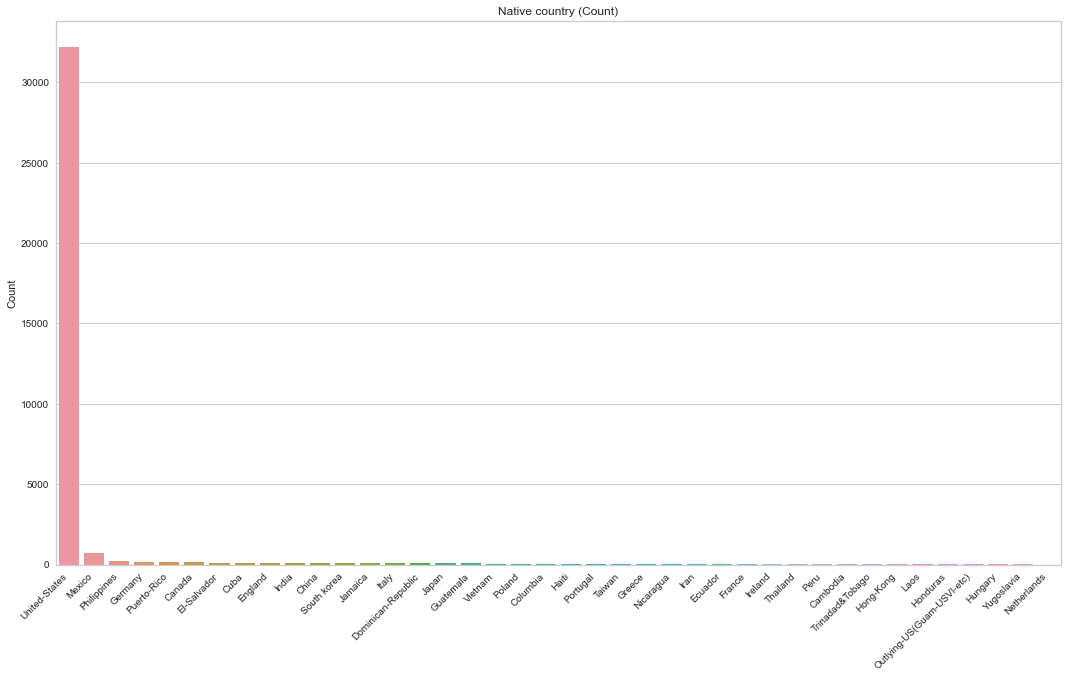

In [478]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'native-country').index, y=value_cnt_norm_cal(train_copy,'native-country')['Count'])
plt.title('Native country (Count)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

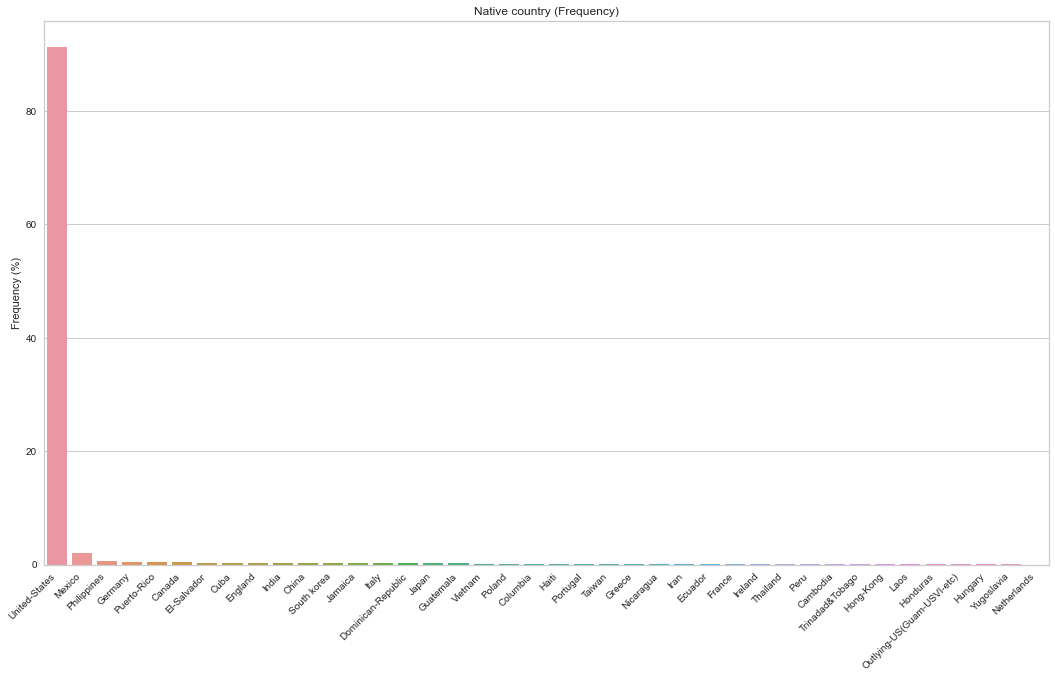

In [479]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'native-country').index, y=value_cnt_norm_cal(train_copy,'native-country')['Frequency (%)'])
plt.title('Native country (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()

In [480]:
# TODO: Native country might be useful but most of the datapoint represent United States. we might need to ingore the other countries.

### 3.4.15 Income > 50 K

In [481]:
train_copy['income_>50K'].dtype

dtype('float64')

In [482]:
train_copy['income_>50K'].isnull().sum()

738

In [483]:
value_cnt_norm_cal(train_copy,'income_>50K')

Count  Frequency (%)
0.000  26642         75.804
1.000   8504         24.196

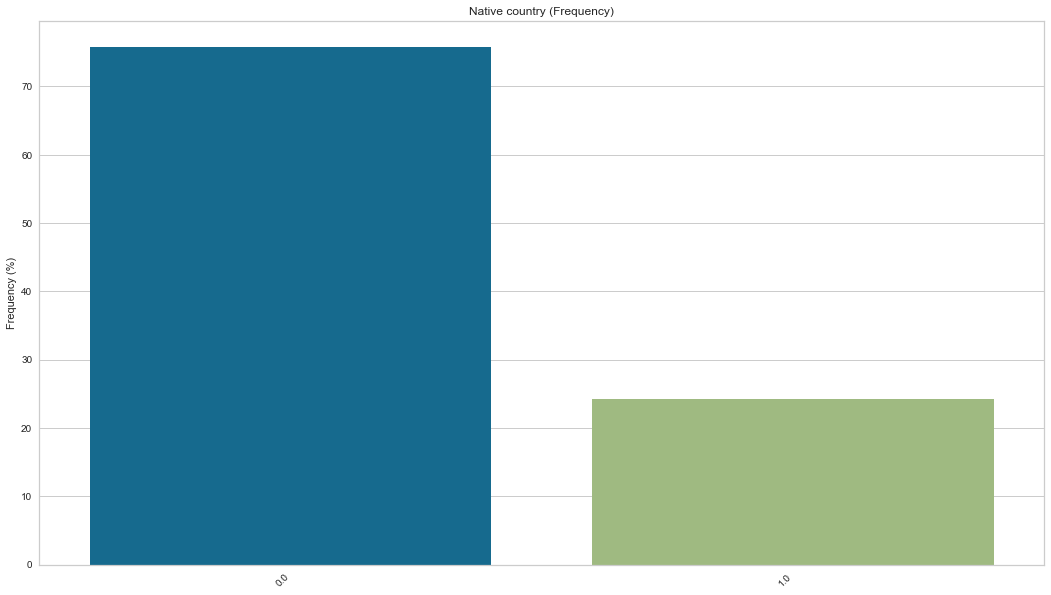

In [484]:
fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(x=value_cnt_norm_cal(train_copy,'income_>50K').index, y=value_cnt_norm_cal(train_copy,'income_>50K')['Frequency (%)'])
plt.title('Native country (Frequency)')
plt.grid(True,axis='y')
plt.xticks(rotation=45,ha='right')
plt.show()


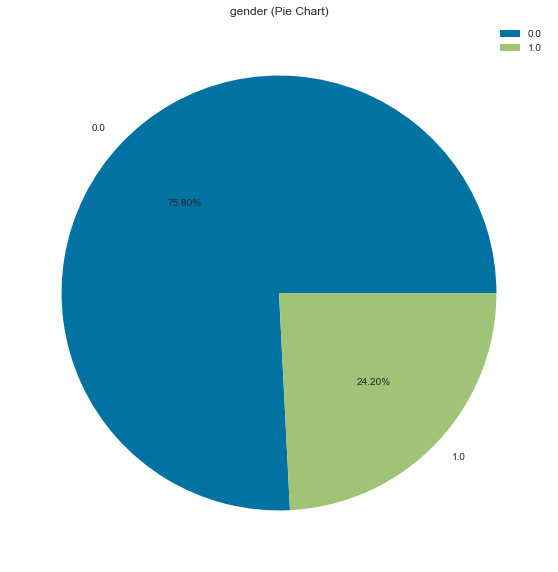

In [485]:
fig, ax = plt.subplots(figsize=(18,10))
plt.pie(train_copy['income_>50K'].value_counts(), labels=train_copy['income_>50K'].value_counts().index, autopct='%1.2f%%')
plt.title('gender (Pie Chart)')
plt.legend(loc='upper right')
plt.show()

In [486]:
# TODO: Our target is imbalance, we will need to oversample before training the model

## 3.5 For supervised learning tasks, identify the target attribute(s).

Tager attribute is the income > 50K

## 3.6 Visualize the data.

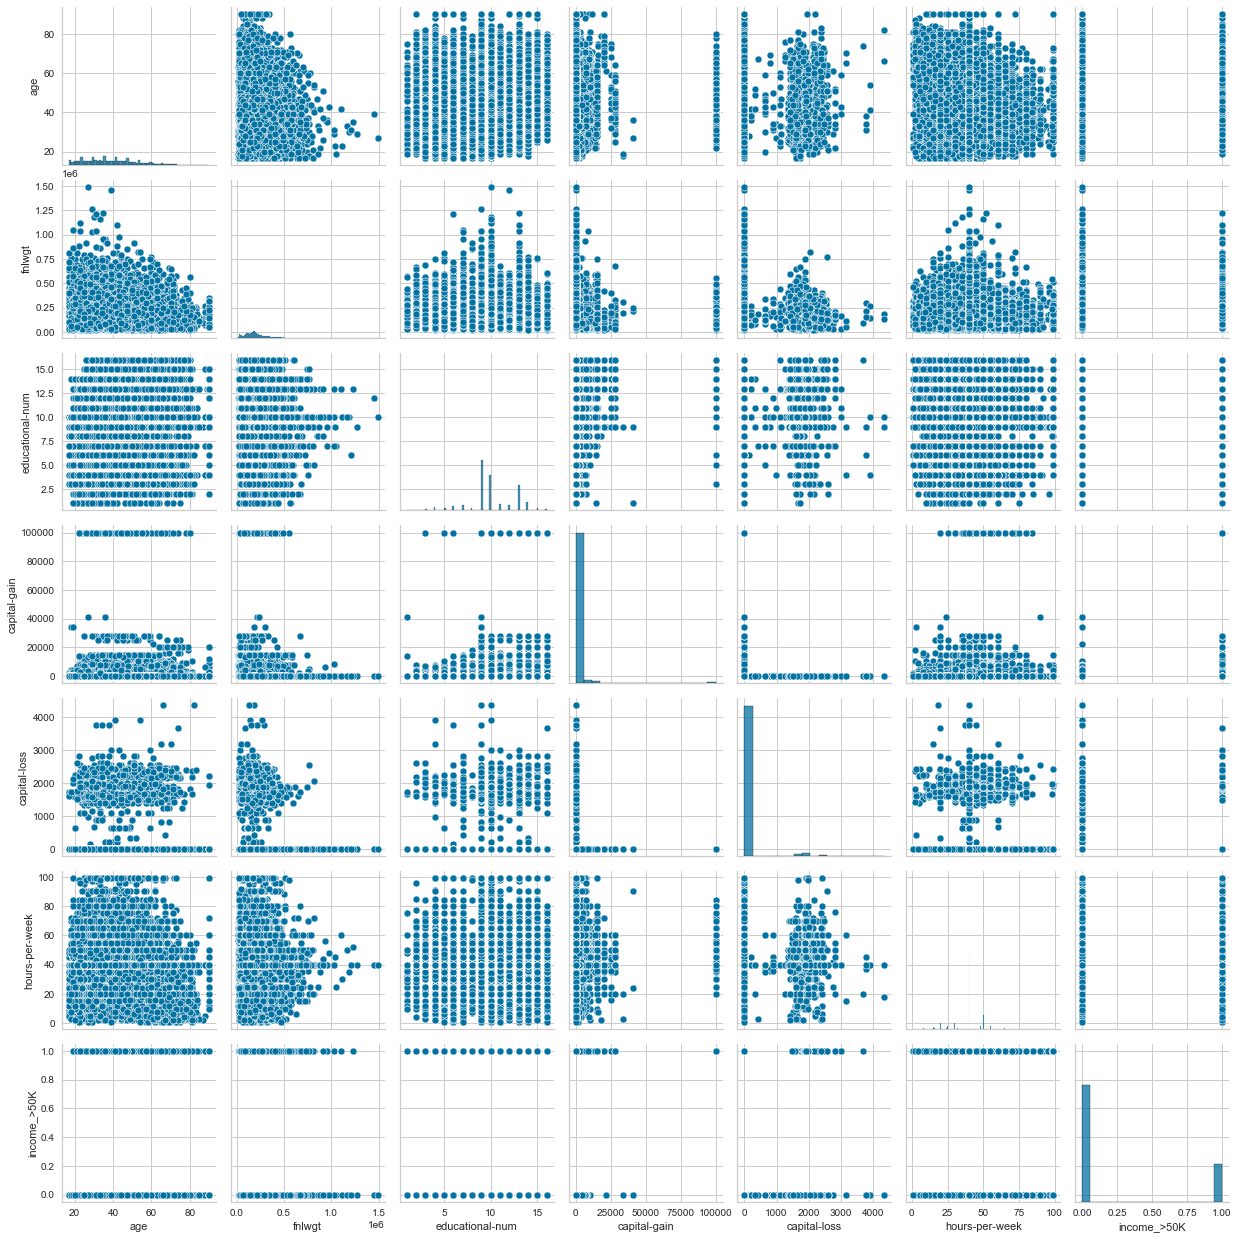

In [487]:
sns.pairplot(train_copy)
plt.show()

## 3.7 Study the pairwise interactions and correlations between attributes.

### 3.7.1 Age vs hours per week (Numerical vs Numerical feature)

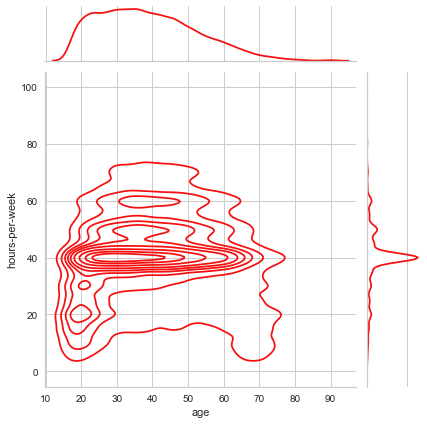

In [488]:
sns.jointplot(x='age', y='hours-per-week', data=train_copy, kind="kde", color="#f50f0f")
plt.grid()
plt.show()

### 3.7.2 Age vs educational number (Numerical vs Numerical feature)

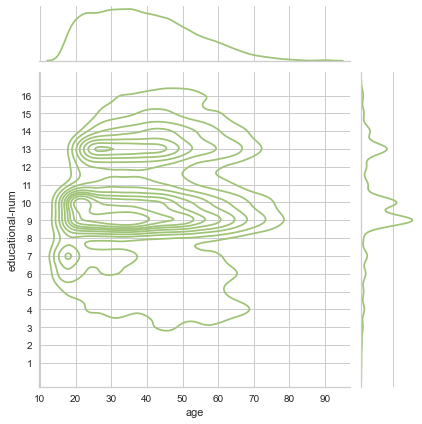

In [489]:
sns.jointplot(x='age', y='educational-num', data=train_copy, kind="kde", color="g")
plt.yticks(np.arange(1, train_copy['educational-num'].nunique()+1, 1))
plt.grid()
plt.show()

In [490]:
education_education_num_relation = pd.DataFrame(train_copy[['education','educational-num']].value_counts()).sort_values(by=['educational-num'], ascending=True).drop([0],axis=1)

In [491]:
education_education_num_relation

Empty DataFrame
Columns: []
Index: [(Preschool, 1), (1st-4th, 2), (5th-6th, 3), (7th-8th, 4), (9th, 5), (10th, 6), (11th, 7), (12th, 8), (HS-grad, 9), (Some-college, 10), (Assoc-voc, 11), (Assoc-acdm, 12), (Bachelors, 13), (Masters, 14), (Prof-school, 15), (Doctorate, 16)]

### 3.7.3 Educational-num vs hours-per-week (Numerical vs Numerical feature)

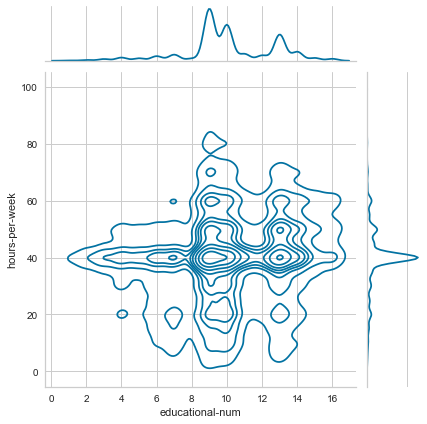

In [492]:
sns.jointplot(x='educational-num', y='hours-per-week', data=train_copy, kind="kde", color="b")
plt.grid()

### 3.7.4 Educational-num vs age (Numerical vs Numerical feature)

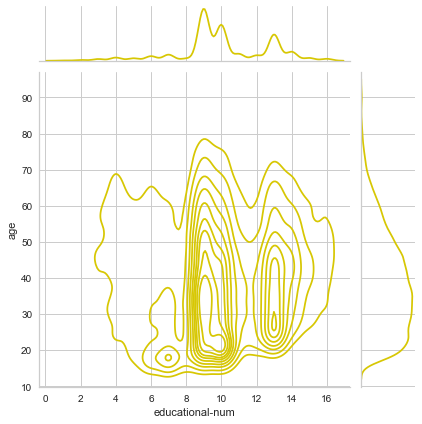

In [493]:
sns.jointplot(x='educational-num', y='age', data=train_copy, kind="kde", color="y")
plt.show()

### 3.7.5 Chi2 test for all the the categorical features (Categorical vs Categorical feature)

In [494]:
def chi2_test(feature_1,feature_2,show_contingency_table=False):
    # creating a cross tabulation of the two features
    feat_1_2_crosstab = pd.crosstab(train_copy[feature_1], train_copy[feature_2])
    stat, p, dof, cont_table = chi2_contingency(feat_1_2_crosstab)
    cont_table_df = pd.DataFrame(cont_table, index=feat_1_2_crosstab.index, columns=feat_1_2_crosstab.columns)
    # toggling the boolean to show the contingency table
    if show_contingency_table:
        print(cont_table_df)
    print('\n')
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    print('\n')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # Different implementation of chi2 test

    # df_ft_1 = df[feature_1].dropna(axis=0, how='any')
    # df_ft_2 = df[feature_2].dropna(axis=0, how='any')
    # data_crosstab = pd.crosstab(df_ft_1,df_ft_2,margins=True, margins_name="Total")

    # # significance level
    # alpha = 0.05

    # Calculation of Chisquare test statistics
    # chi_square = 0
    # rows = df_ft_1.unique()
    # columns = df_ft_2.unique()
    # for i in columns:
    #     for j in rows:
    #         O = data_crosstab[i][j]
    #         E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
    #         chi_square += (O-E)**2/E

    # # The p-value approach
    # print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
    # p_value = 1 - norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
    # conclusion = "Failed to reject the null hypothesis."
    # if p_value <= alpha:
    #     conclusion = "Null Hypothesis is rejected."
    # print("chisquare-score is:", chi_square, " and p value is:", p_value)
    # print(conclusion)
    # # The critical value approach
    # print("\n--------------------------------------------------------------------------------------")
    # print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
    # critical_value = chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
    # conclusion = "Failed to reject the null hypothesis."
    # if chi_square > critical_value:
    #     conclusion = "Null Hypothesis is rejected."
    # print("chisquare-score is:", chi_square, " and p value is:", critical_value)
    # print(conclusion)

In [495]:
all_cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income_>50K']

In [496]:
for i in all_cat_features:
    for j in all_cat_features:
        chi2_test(i,j)



probability=0.950, critical=66.339, stat=237342.000
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=129.918, stat=2476.990
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=58.124, stat=1238.362
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=99.617, stat=9227.727
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=49.802, stat=1393.047
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=41.337, stat=483.317
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=14.067, stat=708.981
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (reject H0)


probability=0.950, critical=312.538, stat=515.328
Dependent (reject H0)


significance=0.050, p=0.000
Dependent (re

### 3.7.6 ANOVA test of age vs the rest of categoricals features (Numerical vs continuous feature)

In [497]:
all_cat_features

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country',
 'income_>50K']

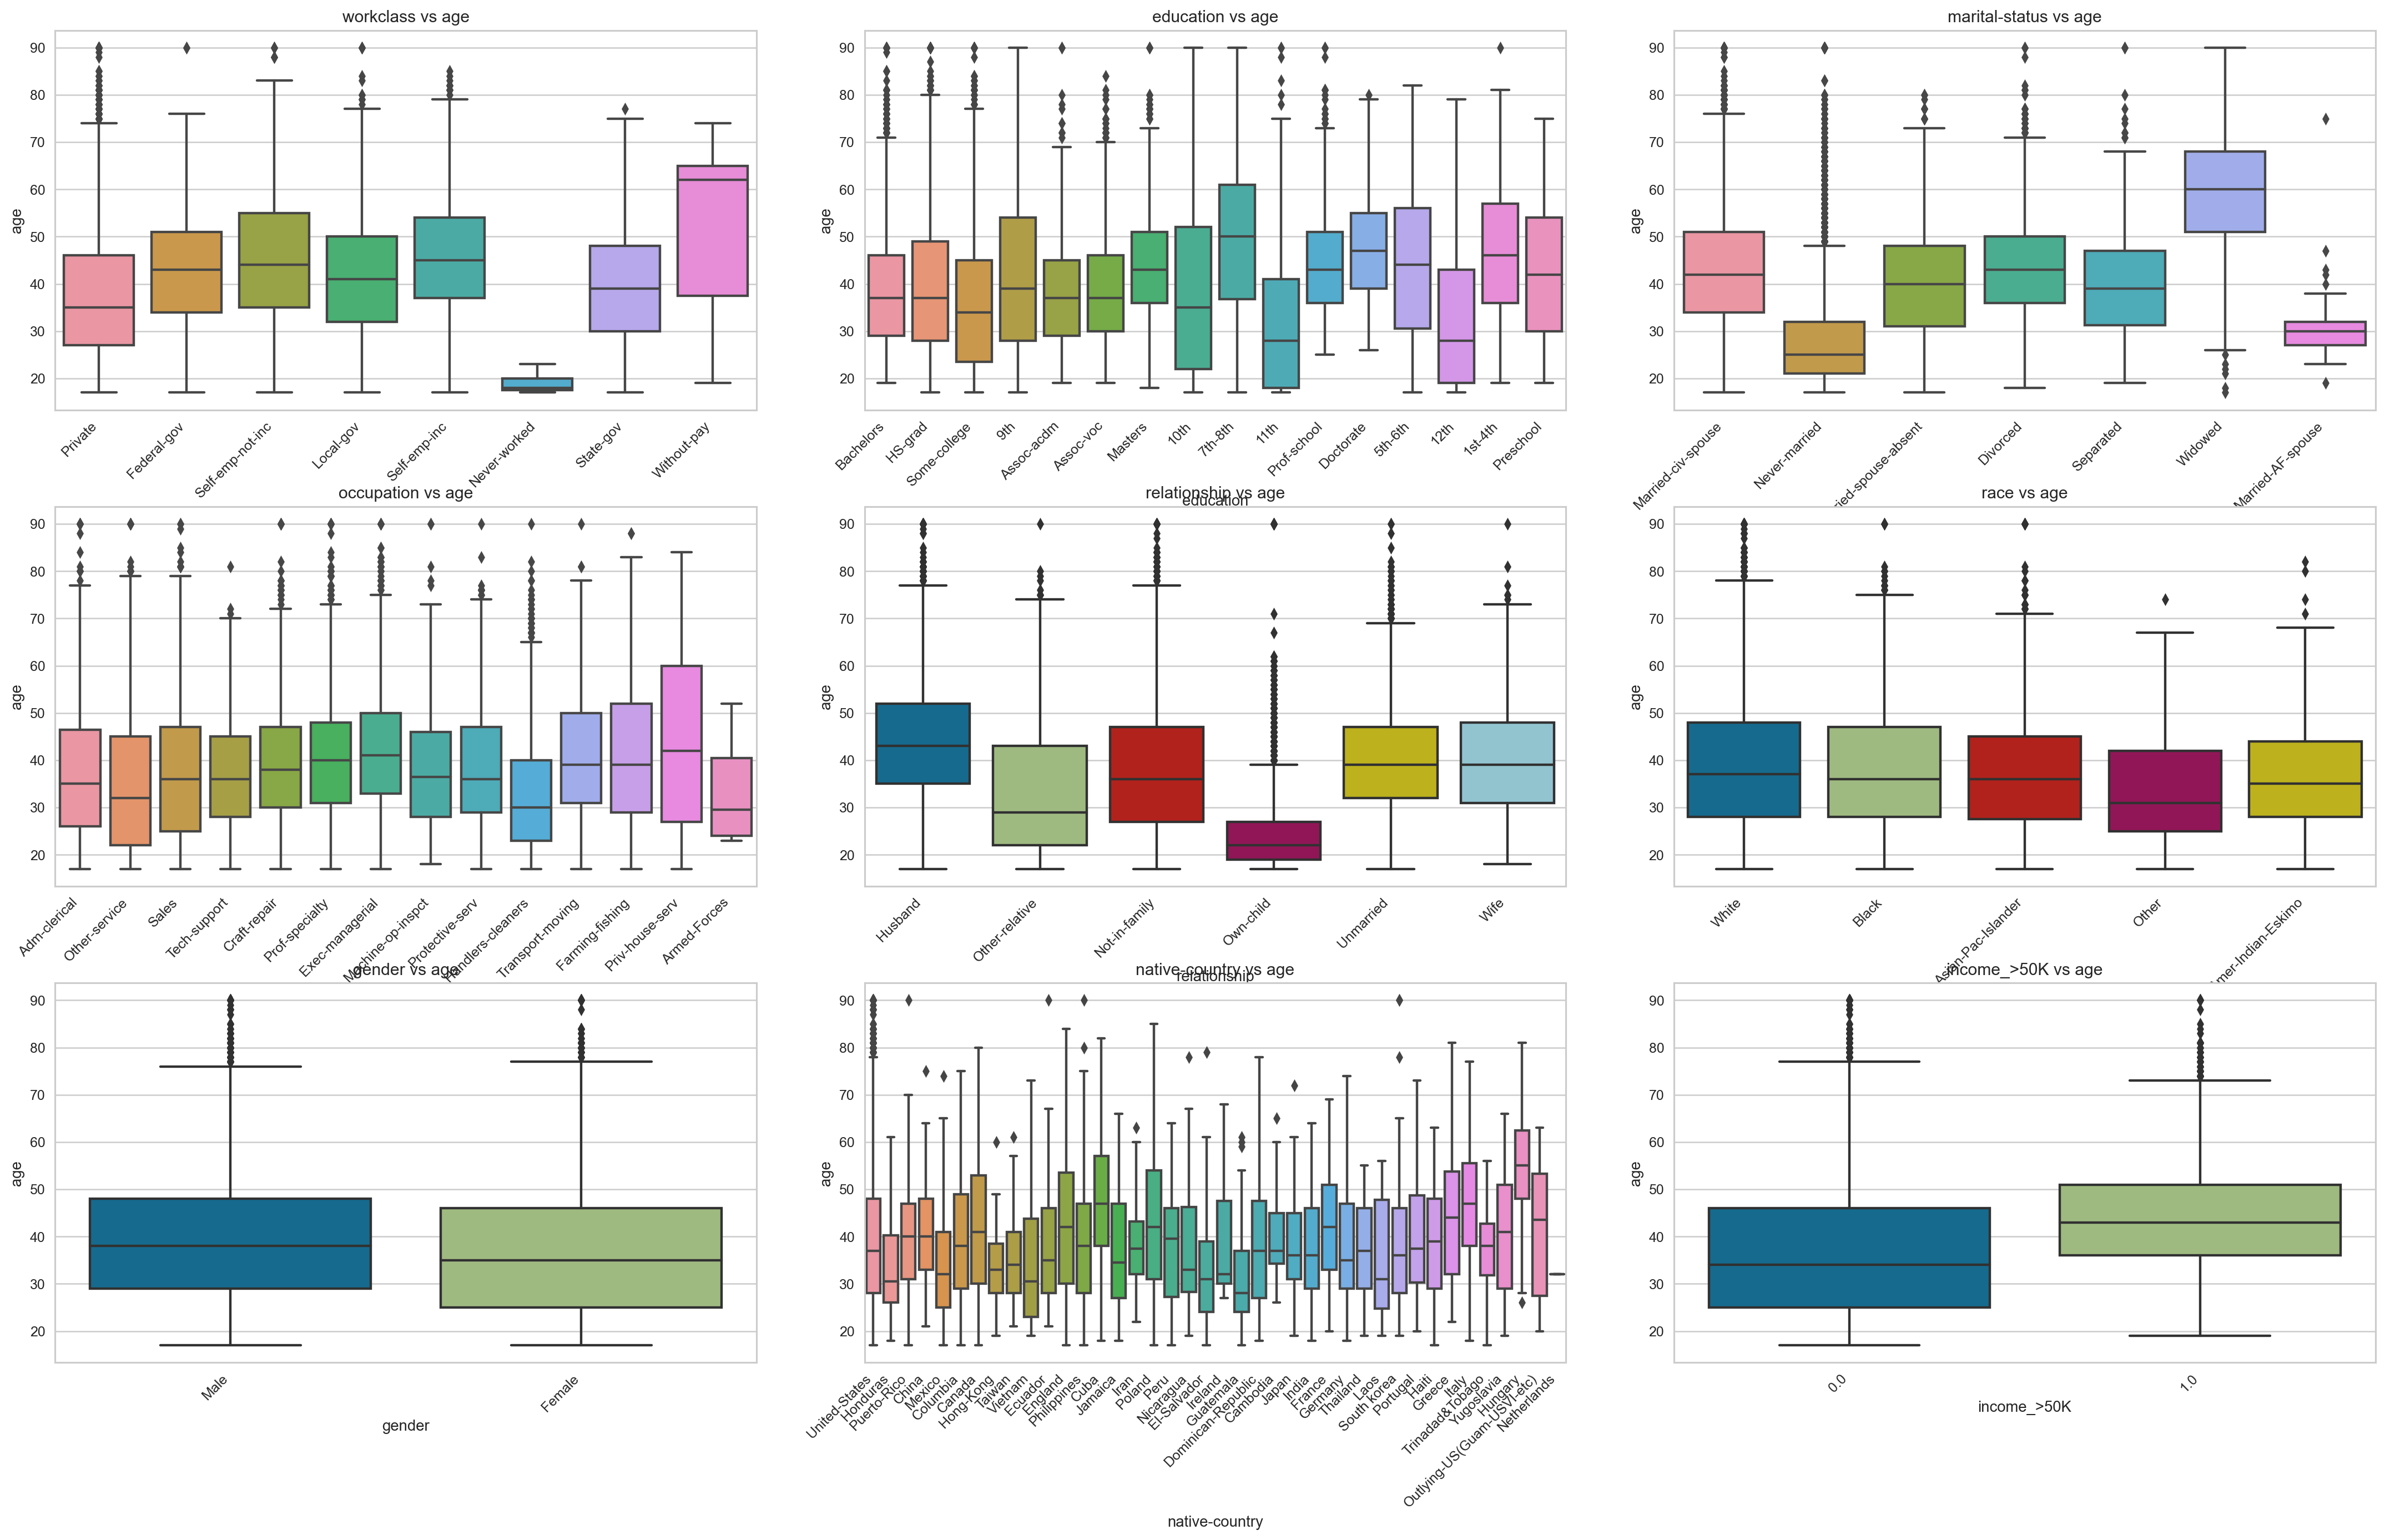

In [498]:
fig, axes = plt.subplots(3,3,figsize=(25,15),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(3):
        for col_count in range(3):
            sns.boxplot(ax=axes[row_count,col_count],x=train_copy[all_cat_features[cat_ft_count]],y=train_copy['age'])
            axes[row_count,col_count].set_title(all_cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,col_count])
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

### 3.7.7 Correlation between features

In [499]:
train_copy_corr = train_copy.corr()

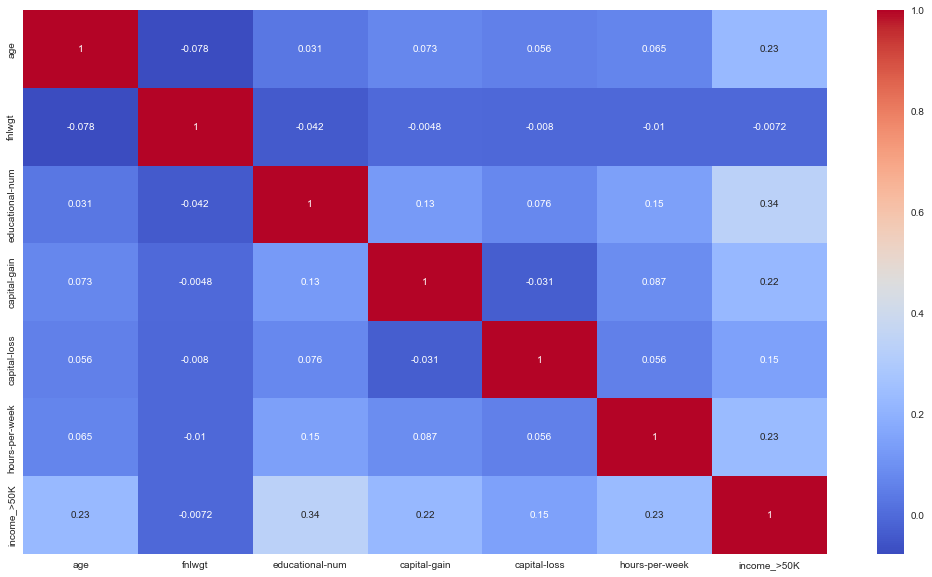

In [500]:
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(train_copy_corr, annot=True, cmap='coolwarm')
plt.show()

In [501]:
mask = np.zeros_like(train_copy_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
train_copy_corr[mask] = np.nan
(train_copy_corr
 .style
 .background_gradient(cmap='bwr', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')
)

## 3.8 Study how you would solve the problem manually.

I would look at the correlation between the features and the target variable. the strongest correlation with the target variable is the age, educational-num, capital-gain and hours-per-week.

## 3.9 Identify the promising transformations you may want to apply.

Age:
- Drop outliers
- Min Max Scaling
- Fix skewness

Workclass:
- drop the feature because highly correlated with occupation with less information (To be done after running the model and seeing the feature importance method)
- one hot encoding

Fnwgt:
- drop the feature because there is no correlation with target

Education:
- One hot encoding

Education-num:
- drop the column(because we will use education feature)

Marital-status:
- One hot encoding
- Create a toggle that will use Marital-status, Relation or both to predict income

Occupation:
- One hot encoding
- Handle missing values

Relation:
- One hot encoding
- Create a toggle that will use Marital-status, Relation or both to predict income

Race:
- One hot encoding

Gender:
- One hot encoding

Capital gain:
- Fix skewness
- Min Max Scaling

Capital loss:
- Fix skewness
- Min Max Scaling

Hours per week:
- Min Max Scaling

Native country:
- Groupe countries into 3 GDP Categories (High, Medium, Low GDP)
- drop the feature because we have extracted the 3 GDP categories

GDP Category(extracted from the Native country):
- One hot encoding those categories

Income (Target):
- Fix imbalance data(SMOTE or oversampling)




## 3.10 Identify extra data that would be useful

In [502]:
# GDP data that will be used to group the countries by their GDP
# GDP data of countries in 1990
# Using 1990 data because the Train and test data is an old dataset. How do I know that? One of the country name is Yugoslavia which is no longer since the mid-1990's.
gdp_data = pd.read_csv('datasets/GDP.csv')

In [503]:
gdp_data.sort_values(by='1990' , inplace=True,ascending=False)

In [504]:
gdp_data.reset_index(inplace=True, drop=True)

In [505]:
gdp_data.rename(columns={'Country Name':'native-country','1990':'GDP_1990'},inplace=True)

In [506]:
gdp_data

native-country  GDP_1990
0                  Monaco 84303.880
1    United Arab Emirates 71359.170
2                  Brunei 54713.545
3           Liechtenstein 49373.610
4              Luxembourg 29664.795
..                    ...       ...
191           Afghanistan   292.000
192            Mozambique   244.601
193               Eritrea   147.000
194               Somalia   126.920
195              Cambodia   100.000

[196 rows x 2 columns]

In [507]:
def add_gdp_data(train_copy,test_copy,gdp_data):
        full_data_copy = pd.concat([train_copy,test_copy],ignore_index=True)
        gdp_group = []
        for idx in gdp_data.index:
            if idx <= 65:
                gdp_group.append('High GDP')
            elif idx >= 65 and idx <= 130:
                gdp_group.append('Medium GDP')
            else:
                gdp_group.append('Low GDP')

        # concatenate the gdp_data with the gdp_group list
        gdp_data = pd.concat([gdp_data.rename(columns={'country':'native-country'}), pd.Series(gdp_group, name='GDP Group')], axis=1)
        # we no longer need the GDP column, so let's drop it
        gdp_data.drop(['GDP_1990'],axis=1,inplace=True)

        # we need to merge the gdp_data with X dataframe
        full_data_copy = pd.merge(full_data_copy, gdp_data, on='native-country', how='left')
        # make income_>50K the last column
        new_col_order = [col for col in full_data_copy.columns if col != 'income_>50K'] + ['income_>50K']
        return full_data_copy[new_col_order]


In [508]:
full_data_copy = add_gdp_data(train_copy,test_copy,gdp_data)

In [509]:
train_copy, test_copy = data_split(full_data_copy,0.2)

## 3.11 Document what you have learned.

All the categorical features are highly correlated (category vs category) and the age and marital status, relationship are highly correlated (numerical vs continuous), finally target is highly correlated with the education, capital gain, age, hour-per-week (numerical vs numerical). 

# 4. Prepare the data for the model

## 4.1 Data cleaning

### 4.1.1 Fix or remove outliers

In [510]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_outliers = ['age']):
        self.col_with_outliers = col_with_outliers
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_outliers).issubset(X.columns)):
            Q1 = X[self.col_with_outliers].quantile(.25)
            Q3 = X[self.col_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            outlier_condition = (X[self.col_with_outliers] < (Q1 - 1.5 * IQR)) | (X[self.col_with_outliers] > (Q3 + 1.5 * IQR))
            index_to_keep = X[~outlier_condition.any(axis=1)].index
            return X.loc[index_to_keep]
        else:
            print("Columns not found")
            return X

### 4.1.2 Fill in missing values (e.g., with zero, mean, median...) or drop their rows (or columns).

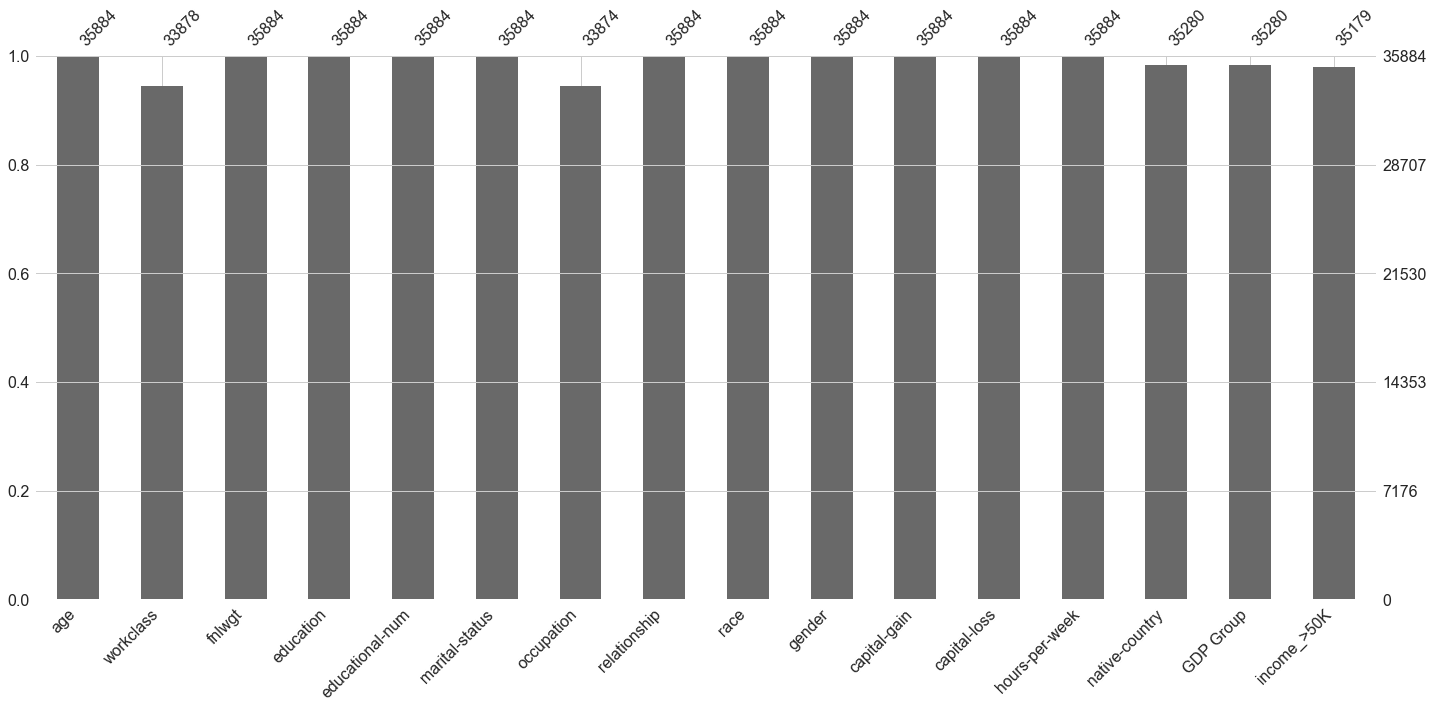

In [511]:
msno.bar(train_copy)
plt.show()

In [512]:
class MissingValHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        # drop all the rows with missing values in X
        X.dropna(inplace=True)
        X.reset_index(inplace=True, drop=True)
        return X

## 4.2 Feature selection

In [513]:
# using the feature importance method from the estimator, drop those features that have a low importance.
# drop_workclass will be called separately after running the model.
# drop_native_country will be called separately after running extraction the GDP group column
class FeatureToDrop(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = {'fnlwgt':True,'educational-num':True,'native-country':False,'workclass':False,'occupation':False}):
        self.feature_to_drop = feature_to_drop
        self.feature_to_drop_list = ['fnlwgt','educational-num']
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        for cols_to_drop in self.feature_to_drop.keys():
            if self.feature_to_drop[cols_to_drop] == True:
                # the column with the keys that were changed to True while initializing the class will be added to the list
                self.feature_to_drop_list.append(cols_to_drop)
        if (set(self.feature_to_drop_list).issubset(X.columns)):
            # drop the columns that were added to the list
            X.drop(self.feature_to_drop_list,axis=1,inplace=True)
            return X
        else:
            print('One or more columns to be dropped not found in the dataframe')
            return X

## 4.3 Feature Engineering and Transformation

### 4.1.3.1 Marital and relationship status toggle

In [514]:
class DropMaritalOrRelationship(BaseEstimator,TransformerMixin):
    def __init__(self, drop_marital=False, drop_relationship=False):
        self.drop_marital = drop_marital
        self.drop_relationship = drop_relationship
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.drop_marital:
            if (set(['marital']).issubset(X.columns)):
                X.drop('marital',axis=1,inplace=True)
                return X
            else:
                print("marital column is not in the dataset")
                return X
        elif self.drop_relationship:
            if (set(['relationship']).issubset(X.columns)):
                X.drop('relationship',axis=1,inplace=True)
                return X
            else:
                print("relationship column is not in the dataset")
                return X
        elif (self.drop_marital) & (self.drop_relationship):
            if (set(['marital','relationship']).issubset(X.columns)):
                X.drop(['marital','relationship'],axis=1,inplace=True)
                return X
            else:
                print("relationship and marital columns are not in the dataset")
                return X
        else:
            print('marital status and relationship are kept in the dataset')
            return X

### 4.1.3.2 Skewness fixings

For more information, refere to [this post](https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55)

In [515]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,col_with_skewness=['age','capital-gain','capital-loss']):
        self.col_with_skewness = col_with_skewness
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.col_with_skewness).issubset(X.columns)):
            # Handle skewness with cubic root transformation
            X[self.col_with_skewness] = np.cbrt(X[self.col_with_skewness])
            return X
        else:
            print('One or more skewed columns are not found')
            return X

### 4.1.3.3 Oversampling with SMOTE

In [516]:
class OversampleSMOTE(BaseEstimator,TransformerMixin):
    def __init__(self, perform_oversampling = True):
        self.perform_oversampling = perform_oversampling
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        # function to oversample the minority class
        if self.perform_oversampling:
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(X.iloc[:,:-1],X.iloc[:,-1])
            X_y_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return X_y_bal
        else:
            print("No oversampling performed")
            return X

## 4.4 Feature scaling

Will be applied directly in the column transformer/pipeline because they are built in functions

## 4.5 Apply the column transformer and pipeline

In [517]:
def smote_pipeline_fuc(df):
    smote_pipeline = Pipeline([
        ('smote', OversampleSMOTE()) # default: perform_oversampling = True
    ])
    smote_pip_result = smote_pipeline.fit_transform(df)
    return smote_pip_result


In [518]:
def concat_fuc(df_ordinal_minmax, df_onehot, df_target):
    concat_df = pd.concat([df_ordinal_minmax, df_onehot, df_target], axis=1)
    return concat_df

In [519]:
def one_hot_enc_fuc(df):
    columns_to_one_hot_enc = ['race', 'gender']
    # all the columns that can potentially be dropped in class FeatureToDrop
    columns_that_can_be_dropped = ['workclass', 'occupation','marital-status', 'relationship', 'native-country']
    for col in columns_that_can_be_dropped:
        if col in df.columns:
            #only do one hot encoding for the columns that are in the dataframe
            columns_to_one_hot_enc.append(col)

    one_hot_enc = OneHotEncoder()
    one_hot_enc.fit(df[columns_to_one_hot_enc])
    # get the result of the one hot encoding columns names
    cols_names_one_hot_enc = one_hot_enc.get_feature_names_out(columns_to_one_hot_enc)
    # change the array of the one hot encoding to a dataframe with the column names
    one_hot_result_with_names_col = pd.DataFrame(one_hot_enc.transform(df[columns_to_one_hot_enc]).toarray(),columns=cols_names_one_hot_enc)
    return one_hot_result_with_names_col

In [520]:
def ordinal_minmax_scaler_fuc(df):
    columns_to_ordinal_enc = ['education', 'GDP Group']
    columns_to_scale = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
    col_transformer = ColumnTransformer([
    ('Ordinal encoder',OrdinalEncoder(),columns_to_ordinal_enc), # ordinal encoding for education and GDP Group because they are ranked
    ('Min max scaler',MinMaxScaler(),columns_to_scale)]) # scaling for age, capital-gain, capital-loss, hours-per-week
    ordinal_minmax_scaler_result = col_transformer.fit_transform(df)
    ordinal_minmax_scaler_result_with_names_col = pd.DataFrame(ordinal_minmax_scaler_result,columns=columns_to_ordinal_enc+columns_to_scale)
    return ordinal_minmax_scaler_result_with_names_col

In [521]:
def extract_target_col(df):
    target = df.iloc[:,-1].to_frame().reset_index(drop=True)
    return target

In [522]:
def initial_pipeline_fuc(df):
    init_pipeline = Pipeline([
        ('Features to drop', FeatureToDrop(feature_to_drop = {'native-country':True,'occupation':True})), #default feature_to_drop_dic = {'fnlwgt':True,'educational-num':True,'native-country':False,'workclass':False,'occupation':False}
        ('Missing values handler', MissingValHandler()), # drop missing values in the whole dataset
        ('Outliers handler', OutlierHandler()),
        ('Drop marital or relationship', DropMaritalOrRelationship()), # default: drop_marital=False, drop_relationship=False
        ('Skewness handler', SkewnessHandler()), # columns with skewness are 'age','capital-gain','capital-loss'
    ])
    init_pip_result = init_pipeline.fit_transform(df)
    return init_pip_result

In [523]:
def full_pipeline_fuc(df):
    # initial pipeline
    init_pip_result = initial_pipeline_fuc(df)
    #extracting the target variable
    target = extract_target_col(init_pip_result)
    # column transformers to apply ordinal and minmax transformation on specific columns
    ordinal_minmax_result = ordinal_minmax_scaler_fuc(init_pip_result)
    #one hot encoding
    one_hot_enc_result = one_hot_enc_fuc(init_pip_result)
    # concat the result from the ordinal and minmax transformation and one hot encoding with the target variable
    encoded_concat_result = concat_fuc(ordinal_minmax_result,one_hot_enc_result,target)
    # balance the imbalance data with smote function
    smote_pip_result = smote_pipeline_fuc(encoded_concat_result)
    return smote_pip_result

In [524]:
train_copy.head(2)

age    workclass  fnlwgt     education  educational-num  \
0   40  Federal-gov  179717       HS-grad                9   
1   29      Private  187479  Some-college               10   

       marital-status    occupation relationship   race gender  capital-gain  \
0  Married-civ-spouse  Adm-clerical      Husband  White   Male          7298   
1  Married-civ-spouse  Craft-repair      Husband  White   Male             0   

   capital-loss  hours-per-week native-country GDP Group  income_>50K  
0             0              50  United-States  High GDP        1.000  
1             0              50  United-States  High GDP        0.000

In [525]:
train_copy_prep = full_pipeline_fuc(train_copy)
train_copy_prep.shape
train_copy_prep.head(2)

marital status and relationship are kept in the dataset


education  GDP Group   age  capital-gain  capital-loss  hours-per-week  \
0     11.000      0.000 0.516         0.418         0.000           0.500   
1     15.000      0.000 0.304         0.000         0.000           0.500   

   race_Amer-Indian-Eskimo  race_Asian-Pac-Islander  race_Black  race_Other  \
0                    0.000                    0.000       0.000       0.000   
1                    0.000                    0.000       0.000       0.000   

   race_White  gender_Female  gender_Male  workclass_Federal-gov  \
0       1.000          0.000        1.000                  1.000   
1       1.000          0.000        1.000                  0.000   

   workclass_Local-gov  workclass_Never-worked  workclass_Private  \
0                0.000                   0.000              0.000   
1                0.000                   0.000              1.000   

   workclass_Self-emp-inc  workclass_Self-emp-not-inc  workclass_State-gov  \
0                   0.000                       0.000                0.000   
1                   0.000                       0.000                0.000   

   workclass_Without-pay  marital-status_Divorced  \
0                  0.000                    0.000   
1                  0.000                    0.000   

   marital-status_Married-AF-spouse  marital-status_Married-civ-spouse  \
0                             0.000                              1.000   
1                             0.000                              1.000   

   marital-status_Married-spouse-absent  marital-status_Never-married  \
0                                 0.000                         0.000   
1                                 0.000                         0.000   

   marital-status_Separated  marital-status_Widowed  relationship_Husband  \
0                     0.000                   0.000                 1.000   
1                     0.000                   0.000                 1.000   

   relationship_Not-in-family  relationship_Other-relative  \
0                       0.000                        0.000   
1                       0.000                        0.000   

   relationship_Own-child  relationship_Unmarried  relationship_Wife  \
0                   0.000                   0.000              0.000   
1                   0.000                   0.000              0.000   

   income_>50K  
0        1.000  
1        0.000

In [526]:
pd.set_option('display.max_columns', None)
train_copy_prep

education  GDP Group   age  capital-gain  capital-loss  hours-per-week  \
0         11.000      0.000 0.516         0.418         0.000           0.500   
1         15.000      0.000 0.304         0.000         0.000           0.500   
2          9.000      0.000 0.346         0.000         0.000           0.459   
3         11.000      0.000 0.533         0.000         0.000           0.480   
4         15.000      0.000 0.425         0.000         0.000           0.653   
...          ...        ...   ...           ...           ...             ...   
48709     11.000      0.000 0.624         0.000         0.000           0.491   
48710     12.000      0.000 0.630         0.000         0.000           0.421   
48711      9.000      0.000 0.555         0.000         0.000           0.602   
48712     15.000      0.000 0.818         0.000         0.000           0.395   
48713     10.000      0.000 0.693         0.953         0.000           0.344   

       race_Amer-Indian-Eskimo  race_Asian-Pac-Islander  race_Black  \
0                        0.000                    0.000       0.000   
1                        0.000                    0.000       0.000   
2                        0.000                    0.000       0.000   
3                        0.000                    0.000       0.000   
4                        0.000                    0.000       0.000   
...                        ...                      ...         ...   
48709                    0.000                    0.000       0.000   
48710                    0.000                    0.000       0.000   
48711                    0.000                    0.000       0.000   
48712                    0.000                    0.000       0.000   
48713                    0.000                    0.000       0.000   

       race_Other  race_White  gender_Female  gender_Male  \
0           0.000       1.000          0.000        1.000   
1           0.000       1.000          0.000        1.000   
2           0.000       1.000          0.000        1.000   
3           0.000       1.000          0.000        1.000   
4           0.000       1.000          0.000        1.000   
...           ...         ...            ...          ...   
48709       0.000       1.000          0.000        1.000   
48710       0.000       1.000          1.000        0.000   
48711       0.000       1.000          0.000        1.000   
48712       0.000       1.000          0.000        1.000   
48713       0.000       1.000          1.000        0.000   

       workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                      1.000                0.000                   0.000   
1                      0.000                0.000                   0.000   
2                      0.000                0.000                   0.000   
3                      0.000                0.000                   0.000   
4                      0.000                0.000                   0.000   
...                      ...                  ...                     ...   
48709                  0.000                0.000                   0.000   
48710                  0.000                0.000                   0.000   
48711                  0.000                0.000                   0.000   
48712                  0.000                0.000                   0.000   
48713                  0.000                0.000                   0.000   

       workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0                  0.000                   0.000                       0.000   
1                  1.000                   0.000                       0.000   
2                  1.000                   0.000                       0.000   
3                  1.000                   0.000                       0.000   
4                  1.000                   0.000                       0.000   
...                  ...                   

In [527]:
test_copy_prep = full_pipeline_fuc(test_copy)
test_copy_prep.shape

marital status and relationship are kept in the dataset


(12160, 35)

In [528]:
X_train_copy_prep = train_copy_prep.iloc[:,:-1]
X_train_copy_prep.shape

(48714, 34)

In [529]:
y_train_copy_prep = train_copy_prep.iloc[:,-1]
y_train_copy_prep.shape

(48714,)

In [530]:
X_test_copy_prep = test_copy_prep.iloc[:,:-1]
X_test_copy_prep.shape

(12160, 34)

In [531]:
y_test_copy_prep = test_copy_prep.iloc[:,-1]
y_test_copy_prep.shape

(12160,)

# 5. Shorlist promising models

## 5.0 Functions to evaluate the model

In [532]:
def create_summary_table(summary_data):
    summary_table_col = [
        'Model name',
        'Precision score (Validation set)',
        'Recall score (Validation set)',
        'F1 score (Validation set)',
        'Accuracy score (Validation set)',
        'AUC score (Validation set)',
        'AUC score (Train set)',
        'Has overfit (AUC score (Train set) > AUC score (Validation set))',
        'Confusion matrix',
        'Roc auc curve',
        'Top 10 important features',
        'Top 10 useless features'
        ]
    summary_df = pd.DataFrame(summary_data, columns=summary_table_col).iloc[[4,6,7,9,10]].style.set_properties(subset=['Confusion matrix','Roc auc curve'], **{'width': '432px','height': '432px'})
    display(HTML(summary_df.to_html()))

In [533]:
def top_and_worst_feat_fuc(col_with_coef):
    top_10_feat, worst_10_feat = col_with_coef[:10], col_with_coef[-10:]
    top_10_feat_str = ""
    worst_10_feat_str = ""
    for count,feat in enumerate(top_10_feat, start=1):
        # top 10 features string formatting
        top_10_feat_str += "{0}. feature name: {1}".format(count,feat[0])+ "<br>" + "coefficient: {:.4f}".format(feat[1]) + "<br>"
    for count,feat in enumerate(worst_10_feat, start=1):
        # worst 10 features string formatting
        worst_10_feat_str += "{0}. feature name: {1}".format(count,feat[0])+ "<br>" + "coefficient: {:.4f}".format(feat[1]) + "<br>"
    return top_10_feat_str, worst_10_feat_str

In [534]:
def check_overfit(auc_score_val_set, auc_score_train_set):
    # if the auc score of the training set is higher than the validation set by more than 0.03, then the model is overfitting
    if (auc_score_train_set - auc_score_val_set) > 0.03:
        return True
    else:
        return False

In [535]:
summary_data = []
def growing_summary_table_fuc(model_name,precision_score,recall_score,f1_score, accuracy_score, auc_score_val_set, auc_score_train_set, is_overfitting, img_conf_matrix, img_roc_auc, col_with_coef):
    if col_with_coef == 'No coeficient or feature importance for this model':
        each_clf_data = [model_name,precision_score,recall_score,f1_score, accuracy_score, auc_score_val_set, auc_score_train_set, is_overfitting, img_conf_matrix, img_roc_auc, col_with_coef, col_with_coef]
        summary_data.append(each_clf_data)
    else:
        top_10_feat, worst_10_feat = top_and_worst_feat_fuc(col_with_coef)
        each_clf_data = [model_name,precision_score,recall_score,f1_score, accuracy_score, auc_score_val_set, auc_score_train_set, is_overfitting, img_conf_matrix, img_roc_auc, top_10_feat, worst_10_feat]
        summary_data.append(each_clf_data)

In [536]:
def roc_curve_fuc(model_trn,model_name,X_train_copy_prep,y_train_copy_prep):
    # path to save the roc curve
    roc_curve_path = Path('saved_preliminary_models/{0}/{0}_roc_curve.jpg'.format(model_name))
    try:
        roc_curve_path.resolve(strict=True)
    except FileNotFoundError:
        print('\n                ROC curve\n')
        lower_than_50k_probs = [0 for _ in range(len(y_train_copy_prep))]
        higher_than_50k_probs = model_trn.predict_proba(X_train_copy_prep)
        higher_than_50k_probs_pos_outcome = higher_than_50k_probs[:,1]
        lower_than_50k_auc = roc_auc_score(y_train_copy_prep,lower_than_50k_probs)
        higher_than_50k_probs_auc = roc_auc_score(y_train_copy_prep,higher_than_50k_probs_pos_outcome)
        #save the auc
        with open('saved_preliminary_models/{0}/lower_than_50k_auc_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(lower_than_50k_auc,handle)
        with open('saved_preliminary_models/{0}/higher_than_50k_probs_auc_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(higher_than_50k_probs_auc,handle)
        # print the auc
        print('Income lower than 50k: ROC AUC=%.3f' % (lower_than_50k_auc))
        print('Income higher than 50k: ROC AUC=%.3f' % (higher_than_50k_probs_auc))
        lower_than_50k_false_pos_rate, lower_than_50k_true_pos_rate, _ = roc_curve(y_train_copy_prep,lower_than_50k_probs)
        higher_than_50k_false_pos_rate, higher_than_50k_true_pos_rate, _ = roc_curve(y_train_copy_prep,higher_than_50k_probs_pos_outcome)
        plt.plot(lower_than_50k_false_pos_rate, lower_than_50k_true_pos_rate, linestyle='--', label='Income lower than 50k')
        plt.plot(higher_than_50k_false_pos_rate, higher_than_50k_true_pos_rate, marker='.', label='Income higher than 50k')
        # axis labels
        plt.xlabel('False Positive Rate (Fall-Out)')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC curve')
        # show the legend
        plt.legend()
        # save the plot
        plt.savefig('saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name))
        # show the plot
        plt.show()
        # creating the html roc auc curve image
        img_roc_auc = '<img src="'+ 'saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name) + '">'
        return higher_than_50k_probs_auc, img_roc_auc
    else:
        # if roc curve path exists, load the auc first
        with open('saved_preliminary_models/{0}/lower_than_50k_auc_{0}.pickle'.format(model_name),'rb') as handle:
                lower_than_50k_auc = pickle.load(handle)
        with open('saved_preliminary_models/{0}/higher_than_50k_probs_auc_{0}.pickle'.format(model_name),'rb') as handle:
                higher_than_50k_probs_auc = pickle.load(handle)
        # print the auc
        print('Income lower than 50k: ROC AUC=%.3f' % (lower_than_50k_auc))
        print('Income higher than 50k: ROC AUC=%.3f' % (higher_than_50k_probs_auc))
        # read the ROC image
        img_roc = mpimg.imread('saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name))
        # plot the ROC image
        img_roc_plot = plt.imshow(img_roc)
        #remove the axis
        plt.axis('off')
        # show the plot
        plt.show()
        # creating the html roc auc curve image
        img_roc_auc = '<img src="'+ 'saved_preliminary_models/{0}/{0}_ROC_curve.jpg'.format(model_name) + '">'
        return higher_than_50k_probs_auc, img_roc_auc


In [537]:
def confusion_matrix_fuc(model_name,y_train_copy_prep,y_train_copy_pred):
    #path to save the confusion matrix
    confusion_matrix_path = Path('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
    try:
        #check if the path exists
        confusion_matrix_path.resolve(strict=True)
    except FileNotFoundError:
        print('\n         Confusion Matrix\n')
        #plot confusion matrix
        confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_train_copy_prep,y_train_copy_pred, cmap='Blues',values_format='d')
        #give a title to the plot using the model name
        plt.title('Confusion Matrix')
        #save the plot as jpg
        plt.savefig('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        #show the plot
        plt.show()
        #img_conf_matrix = 'saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name)
        img_conf_matrix_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name) + '">'
        #img_conf_matrix = Image.open('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        #np_img_conf_matrix = np.array(img_conf_matrix)
        #return np_img_conf_matrix
        return img_conf_matrix_html
    else:
        # plot the confusion matrix image
        img_conf_matrix_html = '<img src="' + 'saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name) + '">'
        img_conf_matrix = mpimg.imread('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        # img_conf_matrix = Image.open('saved_preliminary_models/{0}/{0}_confusion_matrix.jpg'.format(model_name))
        img_conf_matrix_plot = plt.imshow(img_conf_matrix)
        # disable the axis
        plt.axis('off')
        plt.show()
        #return np_img_conf_matrix
        return img_conf_matrix_html

In [538]:
def scores_cal_fuc(model_name,X_train_copy_prep,y_train_copy_prep):
    score_list = ['precision','recall','f1','accuracy','roc_auc']
    scores = []
    scores_mean_for_each_type = []
    scores_mean = 0
    scores_std = 0
    # path to save the model folder
    model_dir_path = Path('saved_preliminary_models/{0}/'.format(model_name))
    files_start_with_score_path = []
    #for loop to check if there is any file start with 'score' in the model folder
    for i in os.listdir(model_dir_path):
        if os.path.isfile(os.path.join(model_dir_path,i)) and 'score' in i:
            files_start_with_score_path.append(os.path.join(model_dir_path,i))
    # file that start with 'score' found, load the scores list, mean and std using pickle
    if files_start_with_score_path:
        for score_type in score_list:
            # load the scores list
            with open('saved_preliminary_models/{0}/score_{1}_list.pickle'.format(model_name,score_type),'rb') as handle:
                scores = pickle.load(handle)
            # load the mean score
            with open('saved_preliminary_models/{0}/score_{1}_mean.pickle'.format(model_name,score_type),'rb') as handle:
                scores_mean = pickle.load(handle)
                scores_mean_for_each_type.append(scores_mean)
            # load the std score
            with open('saved_preliminary_models/{0}/score_{1}_std.pickle'.format(model_name,score_type),'rb') as handle:
                scores_std = pickle.load(handle)
            print('\n                        {} score\n'.format(score_type))
            print('Scores: {}\n'.format(scores))
            print('Mean of the scores: {}\n'.format(scores_mean))
            print('Standard deviation of the scores: {}\n\n'.format(scores_std))
        return scores_mean_for_each_type
    # no file start with score in the model folder
    else:
        for score_type in score_list:
            # calculate the scores for each score type using kfold cross validation
            scores = cross_val_score(model,X_train_copy_prep,y_train_copy_prep,scoring=score_type,cv=10,n_jobs=-1)
            scores_mean = scores.mean()
            scores_mean_for_each_type.append(scores_mean)
            scores_std = scores.std()
            print('\n                        {} score\n'.format(score_type))
            print('Scores: {}\n'.format(scores))
            print('Mean of the scores: {}\n'.format(scores_mean))
            print('Standard deviation of the scores: {}\n\n'.format(scores_std))
            # save the scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_list.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores,handle)
            # save the mean scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_mean.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores_mean,handle)
            # save the standard deviation scores using pickle
            with open('saved_preliminary_models/{0}/score_{1}_std.pickle'.format(model_name,score_type),'wb') as handle:
                pickle.dump(scores_std,handle)
        return scores_mean_for_each_type

In [539]:
def classification_report_fuc(model_name,y_train_copy_prep,y_train_copy_pred):
    # path to save the classification report
    class_rep_path = Path('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name))
    try:
        #check if the path exists
        class_rep_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        print('\n                Classification Report\n')
        #classification report
        cls_rep = classification_report(y_train_copy_prep,y_train_copy_pred)
        print(cls_rep)
        # save the classification report
        with open('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name),'wb') as handle:
            pickle.dump(cls_rep,handle)
        return cls_rep
    else:
        # if it exist load the classification report
        with open('saved_preliminary_models/{0}/class_rep_{0}.pickle'.format(model_name),'rb') as handle:
            cls_rep = pickle.load(handle)
            print('                       {} Classification Report\n'.format(model_name))
            print(cls_rep)
            return cls_rep

In [540]:
def load_coef(model_name):
    with open('saved_preliminary_models/{0}/coef_{0}.pickle'.format(model_name),'rb') as handle:
        col_with_coef = pickle.load(handle)
    # print the coefficients of the model
    print("\nCoefficients for feature importance:\n")
    [print(i) for i in col_with_coef]
    print('\n')
    return col_with_coef

In [541]:
def fit_and_save_coef(X_train_copy_prep, coef):
    columns_names = X_train_copy_prep.columns
    col_with_coef = list(zip(columns_names,coef))
    print("\nCoefficients for feature importance:\n")
    col_with_coef.sort(key=lambda x: x[1],reverse=True)
    [print(i) for i in col_with_coef]
    print('\n')
    # save the coefficients of the model to pickle
    with open('saved_preliminary_models/{0}/coef_{0}.pickle'.format(model_name),'wb') as handle:
        pickle.dump(col_with_coef,handle)
    return col_with_coef

In [542]:
def folder_and_file_model_check(model, model_name, X_train_copy_prep, y_train_copy_prep):
    col_with_coef = []
    # check if the folder with the model name exist and if not create them
    if not os.path.exists('saved_preliminary_models/{}'.format(model_name)):
        os.makedirs('saved_preliminary_models/{}'.format(model_name))
    # check if the model file exist and if not create, train and save it
    model_file_path = Path('saved_preliminary_models/{0}/{0}_model.sav'.format(model_name))
    try:
        model_file_path.resolve(strict=True)
    except FileNotFoundError:
        model_trn = model.fit(X_train_copy_prep,y_train_copy_prep)
        joblib.dump(model_trn,model_file_path)
        # coeficient of the model for feature importance using switch-case statement [new in Python 3.10]
        match model_name:
            # for sgd, logistic regression and linear discriminant analysis, use coef_
            case 'SGD' | 'Logistic_regression' | 'Linear_discriminant_analysis':
                coef_of_each_feat = model_trn.coef_[0]
                col_with_coef = fit_and_save_coef(X_train_copy_prep, coef_of_each_feat)
            #  no coefficients for the svm model as it took a while to train
            case 'Support_vector_machine':
                # no coefficients or feature importance
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            # for decision tree, random forest, gradient boosting, adaboost and Extra_trees, use feature_importances_
            case 'Decision_tree' | 'Random_forest' | 'Gradient_boosting' | 'AdaBoost' | 'Extra_trees':
                coef_of_each_feat = model_trn.feature_importances_
                col_with_coef = fit_and_save_coef(X_train_copy_prep, coef_of_each_feat)
            # does not have does not offer an intrinsic method to evaluate feature importance. refer to https://stackoverflow.com/questions/62933365/how-to-get-the-feature-importance-in-gaussian-naive-bayes, will use permutation_importance
            case 'Gaussian_naive_bayes':
                imps = permutation_importance(model_trn, X_train_copy_prep, y_train_copy_prep)
                coef_of_each_feat = imps.importances_mean
                col_with_coef = fit_and_save_coef(X_train_copy_prep, coef_of_each_feat)
            # Feature importance is not defined for the KNN Classification algorithm
            case 'K-Nearest_neighbors':
                # no coefficients or feature importance
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            case 'Bagging':
                coef_of_each_feat = np.mean([tree.feature_importances_ for tree in model_trn.estimators_], axis=0)
                col_with_coef = fit_and_save_coef(X_train_copy_prep, coef_of_each_feat)
            # Feature importance is not defined for the Neural Network Classification algorithm
            case 'Neural_network':
                # no coefficients or feature importance
                col_with_coef = 'No coeficient or feature importance for this model'
                pass

    else:
        # if it exist load the model
        model_trn = joblib.load(model_file_path)
        # load the coefficients of the model from pickle
        match model_name:
            case 'SGD' | 'Logistic_regression' | 'Linear_discriminant_analysis':
                col_with_coef = load_coef(model_name)
            case 'Support_vector_machine':
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            case 'Decision_tree' | 'Random_forest' | 'Gradient_boosting' | 'AdaBoost' | 'Extra_trees':
                col_with_coef = load_coef(model_name)
            case 'Gaussian_naive_bayes':
                col_with_coef = load_coef(model_name)
            case 'K-Nearest_neighbors':
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
            case 'Bagging':
                col_with_coef = load_coef(model_name)
            case 'Neural_network':
                col_with_coef = 'No coeficient or feature importance for this model'
                pass
    # check if y_train_copy_prep exist and if not create it
    y_train_copy_pred_path = Path('saved_preliminary_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
    try:
        y_train_copy_pred_path.resolve(strict=True)
    except FileNotFoundError:
        #cross validation prediction with kfold = 10
        y_train_copy_pred = cross_val_predict(model_trn,X_train_copy_prep,y_train_copy_prep,cv=10,n_jobs=-1)
        #save the predictions
        joblib.dump(y_train_copy_pred,y_train_copy_pred_path)
        return y_train_copy_pred, model_trn, col_with_coef
    else:
        # if it exist load the predictions
        y_train_copy_pred = joblib.load(y_train_copy_pred_path)
        return y_train_copy_pred, model_trn, col_with_coef

In [543]:
def evaluate_model(model,model_name,X_train_copy_prep,y_train_copy_prep):
    print('\n       ***************  {}  ***************\n'.format(model_name))
    # create the folder and the model file if they don't exist
    y_train_copy_pred,model_trn, col_with_coef = folder_and_file_model_check(model,model_name,X_train_copy_prep,y_train_copy_prep)
    # return the classification report
    classification_report_fuc(model_name,y_train_copy_prep,y_train_copy_pred)
    # print the scores by score type, mean scores and std scores and return the mean scores
    scores_mean= scores_cal_fuc(model_name,X_train_copy_prep,y_train_copy_prep)
    # return the confusion matrix
    img_conf_matrix = confusion_matrix_fuc(model_name,y_train_copy_prep,y_train_copy_pred)
    # return the ROC curve and numpy array of image auc and roc curve
    auc_score_train, img_roc_auc  = roc_curve_fuc(model_trn,model_name,X_train_copy_prep,y_train_copy_prep)
    # check if the model has overfit
    is_overfitting = check_overfit(scores_mean[4],auc_score_train)
    # create a comparison summary table
    growing_summary_table_fuc(model_name, scores_mean[0], scores_mean[1], scores_mean[2], scores_mean[3], scores_mean[4], auc_score_train, is_overfitting, img_conf_matrix, img_roc_auc, col_with_coef)

## 5.1 Quick models comparison

In [544]:
model_dict = {
    'SGD':SGDClassifier(random_state=42,loss='log'),
    'Logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    'Support_vector_machine':SVC(random_state=42,probability=True),
    'Decision_tree':DecisionTreeClassifier(random_state=42),
    'Random_forest':RandomForestClassifier(random_state=42,n_estimators=1000,max_features=20,max_depth=7,min_samples_leaf=3),
    'Gaussian_naive_bayes':GaussianNB(),
    'K-Nearest_neighbors':KNeighborsClassifier(),
    'Gradient_boosting':GradientBoostingClassifier(random_state=42),
    'Linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    'Bagging':BaggingClassifier(random_state=42),
    'Neural_network':MLPClassifier(random_state=42,max_iter=1000),
    'AdaBoost':AdaBoostClassifier(random_state=42),
    'Extra_trees':ExtraTreesClassifier(random_state=42),
}


       ***************  SGD  ***************


Coefficients for feature importance:

('capital-gain', 5.382784155224059)
('gender_Male', 4.702263522499327)
('gender_Female', 4.196706046209869)
('hours-per-week', 4.090378893611647)
('marital-status_Married-civ-spouse', 3.137976894166192)
('race_Asian-Pac-Islander', 2.775360609216332)
('relationship_Wife', 2.7495636773200043)
('age', 2.2467075482556207)
('race_White', 2.2229524291807965)
('workclass_Federal-gov', 2.055754444838591)
('relationship_Not-in-family', 1.9693626808699651)
('workclass_Self-emp-inc', 1.8183536021739584)
('workclass_Local-gov', 1.6961214069028514)
('relationship_Unmarried', 1.6821269655686555)
('capital-loss', 1.6314176159041258)
('relationship_Husband', 1.6113417237207122)
('race_Black', 1.597201294120338)
('workclass_State-gov', 1.4651454253298728)
('marital-status_Married-AF-spouse', 1.3943483371493155)
('workclass_Private', 1.3223671725014234)
('race_Other', 1.2747272934211133)
('race_Amer-Indian-Eskimo', 1.0

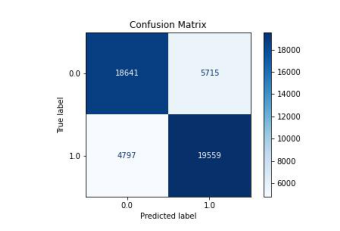

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.867


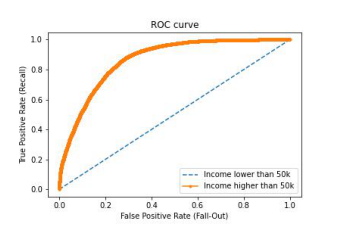


       ***************  Logistic_regression  ***************


Coefficients for feature importance:

('capital-gain', 5.426649107549949)
('hours-per-week', 3.9730633656876635)
('age', 2.136655891497043)
('marital-status_Married-civ-spouse', 1.6689482427105504)
('capital-loss', 1.5856626806850256)
('relationship_Wife', 1.1891348508537833)
('marital-status_Married-AF-spouse', 1.0808134080637906)
('race_Asian-Pac-Islander', 0.9632500795628733)
('workclass_Federal-gov', 0.8610865354418379)
('workclass_Self-emp-inc', 0.6336759807177055)
('relationship_Not-in-family', 0.5119813209357842)
('workclass_Local-gov', 0.5059656676669596)
('race_White', 0.38938264431416547)
('gender_Male', 0.29142454558597125)
('workclass_State-gov', 0.2875530452064398)
('relationship_Unmarried', 0.22799102497381335)
('workclass_Private', 0.16768297000909946)
('relationship_Husband', 0.12641887973034532)
('education', 0.06485724803138097)
('race_Black', -0.18673034053495416)
('gender_Female', -0.23771556374348068)


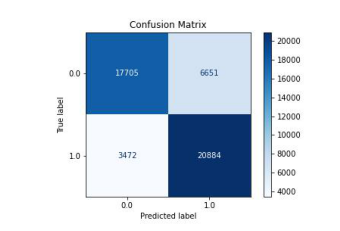

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.868


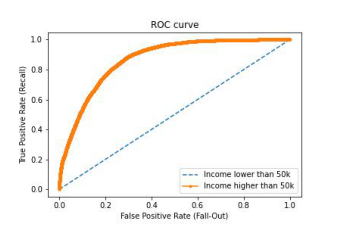


       ***************  Support_vector_machine  ***************

                       Support_vector_machine Classification Report

              precision    recall  f1-score   support

         0.0       0.85      0.70      0.77     24356
         1.0       0.75      0.88      0.81     24356

    accuracy                           0.79     48712
   macro avg       0.80      0.79      0.79     48712
weighted avg       0.80      0.79      0.79     48712


                        precision score

Scores: [0.74753173 0.7500875  0.7433844  0.74572724 0.74868559 0.74492652
 0.74886324 0.7415493  0.74060021 0.74441341]

Mean of the scores: 0.7455769146959075

Standard deviation of the scores: 0.0030368793544429435



                        recall score

Scores: [0.87027915 0.87972085 0.87679671 0.87802875 0.87720739 0.87433265
 0.87889984 0.86453202 0.88136289 0.87520525]

Mean of the scores: 0.8756365503080081

Standard deviation of the scores: 0.004728173226174255



                 

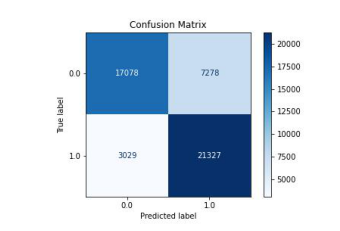

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.859


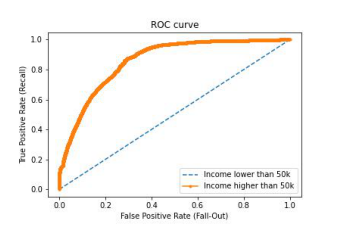


       ***************  Decision_tree  ***************


Coefficients for feature importance:

('marital-status_Married-civ-spouse', 0.31820845584729934)
('age', 0.192286317638936)
('hours-per-week', 0.13703101468050727)
('capital-gain', 0.10704113556788271)
('education', 0.1047005478960992)
('capital-loss', 0.027616286261235124)
('workclass_Private', 0.01316652996543388)
('workclass_Self-emp-not-inc', 0.008763431827804981)
('race_White', 0.00830921550424064)
('GDP Group', 0.0075713224995154855)
('workclass_Local-gov', 0.007476414711834879)
('gender_Male', 0.007249688881751293)
('workclass_Self-emp-inc', 0.006281842673478024)
('gender_Female', 0.005904728235385073)
('race_Black', 0.005695703602432213)
('workclass_State-gov', 0.0053546073218589925)
('relationship_Not-in-family', 0.005327429712309712)
('workclass_Federal-gov', 0.004057827073724014)
('relationship_Wife', 0.003396336086056753)
('relationship_Husband', 0.0032157770422118477)
('race_Asian-Pac-Islander', 0.002961313250408668

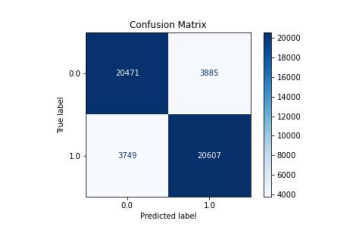

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.994


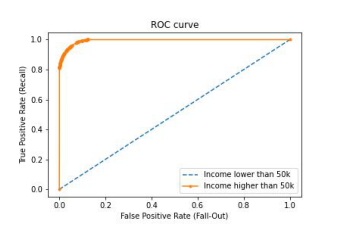


       ***************  Random_forest  ***************


Coefficients for feature importance:

('marital-status_Married-civ-spouse', 0.38558888104843847)
('capital-gain', 0.14266634268005338)
('relationship_Husband', 0.11042875093046986)
('hours-per-week', 0.08939049450860227)
('age', 0.08874296453933848)
('education', 0.08643049781173961)
('marital-status_Never-married', 0.03581845890406981)
('relationship_Wife', 0.026165883120892658)
('capital-loss', 0.017756118342376254)
('relationship_Not-in-family', 0.00611196700014564)
('relationship_Own-child', 0.0021468758727925053)
('workclass_Self-emp-not-inc', 0.0018553322968305915)
('marital-status_Divorced', 0.0016061668447150844)
('gender_Female', 0.000929462444003012)
('gender_Male', 0.0007558864440553502)
('race_White', 0.0004987445144365609)
('GDP Group', 0.0004906896102911811)
('relationship_Unmarried', 0.0004547799218047105)
('workclass_Private', 0.00042642494254684733)
('workclass_Self-emp-inc', 0.0003870475042333374)
('workclass_L

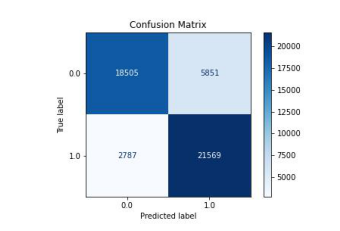

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.915


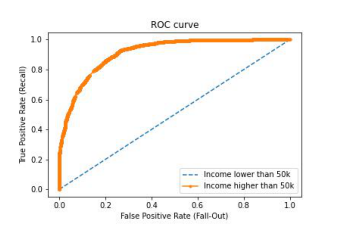


       ***************  Gaussian_naive_bayes  ***************


Coefficients for feature importance:

('relationship_Own-child', 0.05015601905074725)
('marital-status_Never-married', 0.026527344391525688)
('relationship_Not-in-family', 0.02122680243061259)
('capital-gain', 0.01919444900640499)
('marital-status_Married-civ-spouse', 0.018016094596813904)
('marital-status_Divorced', 0.0128921005091148)
('relationship_Other-relative', 0.010354738052225332)
('relationship_Unmarried', 0.01012070947610444)
('age', 0.009258498932501236)
('marital-status_Separated', 0.008782230251272805)
('relationship_Husband', 0.0086754803744457)
('marital-status_Widowed', 0.008092461816390183)
('workclass_Self-emp-inc', 0.00436853342092296)
('relationship_Wife', 0.0034488421744128584)
('capital-loss', 0.0028617178518639983)
('marital-status_Married-spouse-absent', 0.0027919198554770875)
('race_Amer-Indian-Eskimo', 0.0023156511742486565)
('race_Other', 0.0016751519132862437)
('hours-per-week', 0.001079816061

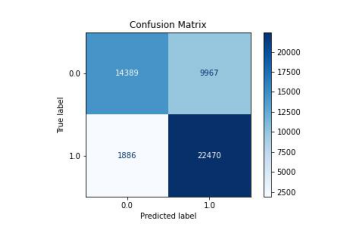

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.849


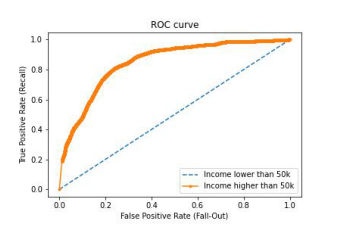


       ***************  K-Nearest_neighbors  ***************

                       K-Nearest_neighbors Classification Report

              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83     24356
         1.0       0.81      0.87      0.84     24356

    accuracy                           0.83     48712
   macro avg       0.84      0.83      0.83     48712
weighted avg       0.84      0.83      0.83     48712


                        precision score

Scores: [0.8002341  0.8097503  0.80488766 0.8082607  0.81428571 0.8160091
 0.81630353 0.81329827 0.80968219 0.81533233]

Mean of the scores: 0.8108043901494779

Standard deviation of the scores: 0.005017472925398377



                        recall score

Scores: [0.84195402 0.83866995 0.8386037  0.87597536 0.88952772 0.88336756
 0.89203612 0.88875205 0.89942529 0.886289  ]

Mean of the scores: 0.8734600769430478

Standard deviation of the scores: 0.022799765402288546



                        f

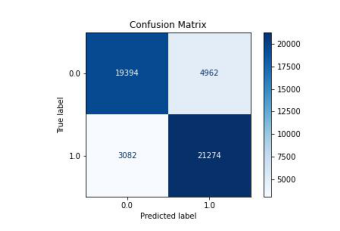

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.955


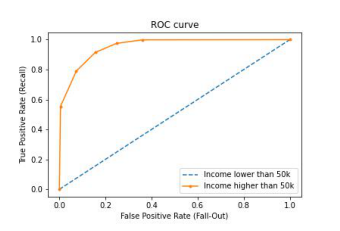


       ***************  Gradient_boosting  ***************


Coefficients for feature importance:

('marital-status_Married-civ-spouse', 0.4781828804634255)
('capital-gain', 0.1493984110534449)
('education', 0.11220062493845538)
('age', 0.10927995254229257)
('hours-per-week', 0.0916289278170947)
('capital-loss', 0.028402928187077257)
('race_White', 0.005461738025565324)
('workclass_Self-emp-not-inc', 0.005120199157808906)
('relationship_Not-in-family', 0.004082883022131451)
('relationship_Wife', 0.003982755756026212)
('workclass_Federal-gov', 0.0022925201100171795)
('GDP Group', 0.0020982353021450867)
('workclass_Self-emp-inc', 0.0013647591062277327)
('relationship_Own-child', 0.0013121846403956765)
('relationship_Husband', 0.001078283810280134)
('relationship_Other-relative', 0.0010354928831237742)
('gender_Female', 0.0006010827023798651)
('workclass_Private', 0.0005235604241582591)
('gender_Male', 0.0004417575387662593)
('race_Asian-Pac-Islander', 0.0004165539022660035)
('workclass_

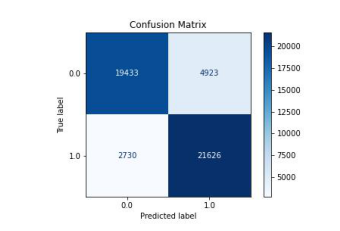

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.929


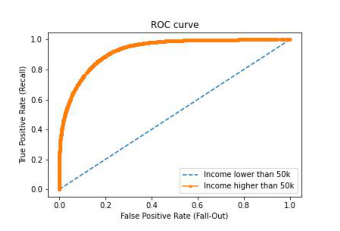


       ***************  Linear_discriminant_analysis  ***************


Coefficients for feature importance:

('capital-gain', 4.062734518976571)
('hours-per-week', 3.4879765799122606)
('age', 2.0284644833411543)
('capital-loss', 1.6788845199911024)
('relationship_Wife', 1.5683888180341734)
('marital-status_Married-civ-spouse', 0.8379742976488658)
('workclass_Federal-gov', 0.7012498415176168)
('race_Asian-Pac-Islander', 0.6813365620388374)
('relationship_Husband', 0.639979140580235)
('workclass_Local-gov', 0.3119469939072148)
('workclass_Self-emp-inc', 0.3097131654342896)
('gender_Male', 0.19480167593327652)
('race_White', 0.15857196394344242)
('marital-status_Married-AF-spouse', 0.09504694695324126)
('education', 0.05146519641234725)
('workclass_State-gov', 0.048405356978441186)
('workclass_Private', -0.07313369596822733)
('gender_Female', -0.19480167593327488)
('workclass_Never-worked', -0.24002070953063476)
('race_Black', -0.3757788593116298)
('marital-status_Married-spouse-absent'

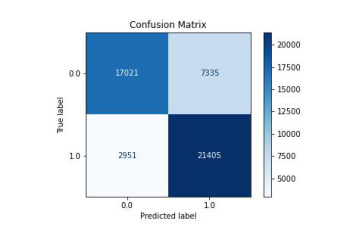

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.864


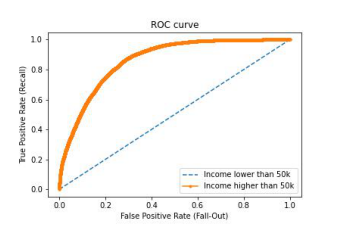


       ***************  Bagging  ***************


Coefficients for feature importance:

('marital-status_Married-civ-spouse', 0.3107845374049361)
('age', 0.19735249776268762)
('hours-per-week', 0.1404117293647143)
('capital-gain', 0.1042759233880249)
('education', 0.10415478770382489)
('capital-loss', 0.028027794100415632)
('workclass_Private', 0.012616881250061546)
('race_White', 0.008864547523681472)
('workclass_Self-emp-not-inc', 0.008676447738822018)
('GDP Group', 0.008674240402677728)
('workclass_Local-gov', 0.007914498909307609)
('workclass_State-gov', 0.005795311069910674)
('workclass_Self-emp-inc', 0.005688327621674932)
('gender_Male', 0.00557717397330665)
('race_Black', 0.005518029772197297)
('relationship_Not-in-family', 0.005342857873812718)
('gender_Female', 0.005093577455939092)
('relationship_Wife', 0.004699697022671743)
('workclass_Federal-gov', 0.004624573289747537)
('race_Asian-Pac-Islander', 0.004132726255062091)
('relationship_Husband', 0.003545528238583933)
('mari

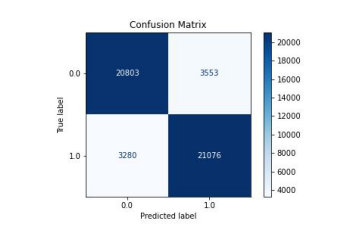

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.991


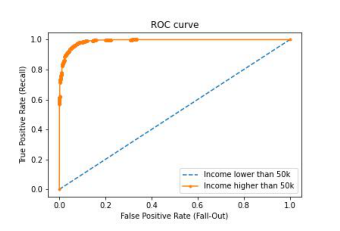


       ***************  Neural_network  ***************

                       Neural_network Classification Report

              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82     24356
         1.0       0.79      0.88      0.84     24356

    accuracy                           0.83     48712
   macro avg       0.83      0.83      0.83     48712
weighted avg       0.83      0.83      0.83     48712


                        precision score

Scores: [0.7820841  0.78681885 0.81135987 0.81676413 0.81491195 0.80324245
 0.78830283 0.79844961 0.76494565 0.78103208]

Mean of the scores: 0.7947911522084121

Standard deviation of the scores: 0.016106460260701037



                        recall score

Scores: [0.87807882 0.8772578  0.8036961  0.86036961 0.89322382 0.89527721
 0.90188834 0.88793103 0.92446634 0.91954023]

Mean of the scores: 0.8841729296689291

Standard deviation of the scores: 0.03245868613972561



                        f1 score

S

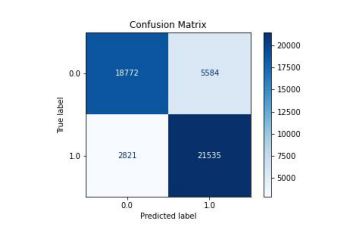

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.928


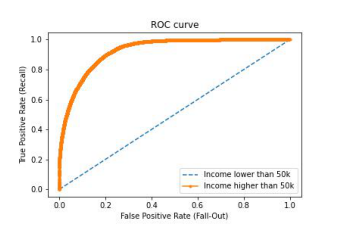


       ***************  AdaBoost  ***************


Coefficients for feature importance:

('education', 0.22)
('capital-gain', 0.18)
('age', 0.16)
('capital-loss', 0.14)
('hours-per-week', 0.1)
('GDP Group', 0.02)
('race_Asian-Pac-Islander', 0.02)
('race_White', 0.02)
('gender_Female', 0.02)
('workclass_Federal-gov', 0.02)
('workclass_Self-emp-not-inc', 0.02)
('marital-status_Married-civ-spouse', 0.02)
('relationship_Not-in-family', 0.02)
('relationship_Own-child', 0.02)
('relationship_Wife', 0.02)
('race_Amer-Indian-Eskimo', 0.0)
('race_Black', 0.0)
('race_Other', 0.0)
('gender_Male', 0.0)
('workclass_Local-gov', 0.0)
('workclass_Never-worked', 0.0)
('workclass_Private', 0.0)
('workclass_Self-emp-inc', 0.0)
('workclass_State-gov', 0.0)
('workclass_Without-pay', 0.0)
('marital-status_Divorced', 0.0)
('marital-status_Married-AF-spouse', 0.0)
('marital-status_Married-spouse-absent', 0.0)
('marital-status_Never-married', 0.0)
('marital-status_Separated', 0.0)
('marital-status_Widowed', 0

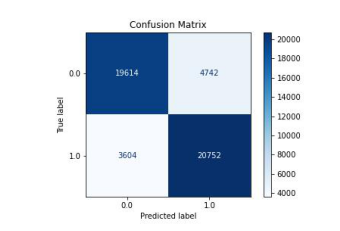

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.918


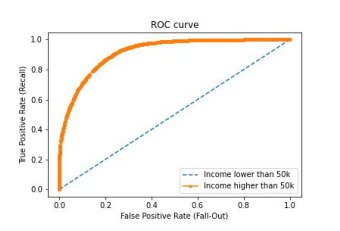


       ***************  Extra_trees  ***************


Coefficients for feature importance:

('age', 0.21684122803938724)
('hours-per-week', 0.13653646782341244)
('education', 0.11986510754822444)
('marital-status_Married-civ-spouse', 0.10398898284190472)
('capital-gain', 0.0834396496293251)
('marital-status_Never-married', 0.06030667477359609)
('relationship_Husband', 0.05907067019715362)
('capital-loss', 0.026943229361114325)
('relationship_Own-child', 0.02594743147852803)
('relationship_Not-in-family', 0.02433934027673236)
('relationship_Wife', 0.017327749694230413)
('gender_Male', 0.013612801993778912)
('marital-status_Divorced', 0.011786764869458795)
('relationship_Unmarried', 0.011659619228738437)
('gender_Female', 0.011167239840212652)
('workclass_Private', 0.009757443105329187)
('GDP Group', 0.009466137297573183)
('race_White', 0.007399296455375459)
('workclass_Self-emp-not-inc', 0.00709401193202317)
('workclass_Self-emp-inc', 0.006598793137952038)
('race_Black', 0.00484421628

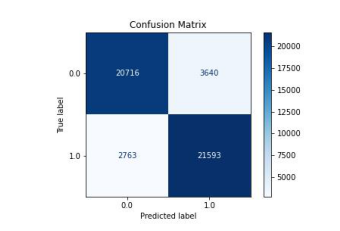

Income lower than 50k: ROC AUC=0.500
Income higher than 50k: ROC AUC=0.994


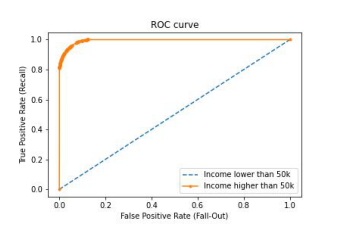

In [545]:
for model_name,model in model_dict.items():
    evaluate_model(model,model_name,X_train_copy_prep,y_train_copy_prep)

In [546]:
create_summary_table(summary_data)

## 5.3. Analyze the most significant variables for each algorithm.
### (For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds)

Done in quick models comparison

## 5.4 Analyze the types of errors the models make.

### 5.4.1 While keeping all the features

We will focus on 5 models: Random forest, Bagging, Gradient boosting, KNN, and Neural network.

* For Random forest: Looking at the confusion matrix, the estimator is making more errors on False Positive(5852 times), meaning that we are predicting an income higher than 50K but the income is actually lower than 50K. False Negative is low at 2377 times.
* For KNN: Looking at the confusion matrix, the estimator is making also errors on False Positive but a bit less than the Random forest(5281 times). False negative is low as well at 2607 times
* For Gradient Boosting: Looking at the confusion matrix, the estimator is making some errors on False Positive but way less than the Random forest or KNN(4423 times). False negative is relatively low at 2499 times.
* For Bagging: False positive is low compare to the other models at 2948 times. False negative is high at 3327 times.
* For neural network: False positive is high at 4385 times and False negative is low at 2912 times.


Conclusion: It seems that in general, the model are making more errors on False Positive than on False Negative except fir the Bagging model.

Solution to this issue would be for example to gather more data that represent people with an income more than 50K. The root of this issue would be the fact that we have balance the data set using the SMOTE method(by duplicating the minority class)

### 5.4.2 While dropping native-country and occupation

## 5.5 Perform a quick round of feature selection and engineering.

Dropping native-country and occupation to see if this improves the performace of the models, which does not improv

In [214]:
rf_class = RandomForestClassifier(random_state=42,n_estimators=1000,max_features=20,max_depth=7,min_samples_leaf=3)

In [219]:
viz = FeatureImportances(rf_class,topn=-10)

/Users/sternsemasuka/miniforge3/envs/.income_pred_env/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


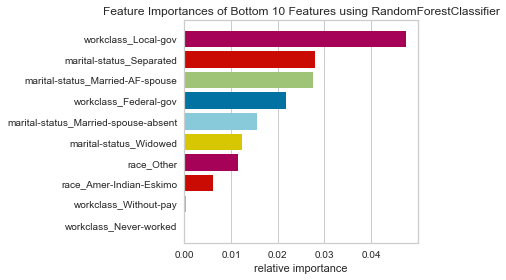

<AxesSubplot:title={'center':'Feature Importances of Bottom 10 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [220]:
viz.fit(X_train_copy_prep,y_train_copy_prep)
viz.show()

In [547]:
# TODO: add the feature importance (top 10 and bottom 10)using Yellowbrick plots and replace the two last columns in the summary table
# TODO: implement the same drop methodology use in FeatureToDrop class in DropMaritalOrRelationship class
# TODO: create a save the summary table data frame mechanism
# TODO: using the bottom 10 features, toggle to drop occupation, native country, workclass, (marital and relationship) and compare the result in the summary table. Automate this with a loop/combination